In [ ]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy as sp
import jax
from jax import jit, vmap, grad, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from functools import partial
import os
if not os.path.exists('figures'):
    os.makedirs('figures')

sns.set_style('whitegrid')

!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
def df_1(etas, lamb):
  return jnp.mean(etas/(lamb+etas))

def df_1p(etas, lamb):
  return jnp.mean(etas/(lamb+etas)**2)

def g_1(etas, lamb):
  return jnp.mean(1.0/(lamb+etas))

def df_2(etas, lamb):
  return jnp.mean((etas/(lamb+etas))**2)

def tf_1(etas, ws, lamb):
  return jnp.sum((ws**2) * etas/(lamb+etas))

def tf_1p(etas, ws, lamb):
  return jnp.sum((ws**2)*etas/(lamb+etas)**2)

def newton(f, x0, max_step=100, abs_tol=1e-5, rel_tol=1e-5, eta=1.0):
    x = x0
    gf = grad(f)
    for _ in range(max_step):
        x_next = x - eta*f(x)/gf(x)
        if (abs(f(x_next)) < abs_tol) or (abs(f(x_next)) < rel_tol * gf(x)):
            return x_next
        x = x_next

def bisect(f, xl, xu, max_step=100, abs_tol=1e-5):
    x = (xl + xu)/2
    for _ in range(max_step):
        if (abs(f(x)) < abs_tol):
            return x
        if f(xl)*f(x) < 0:
            xu = x
        else:
            xl = x
        x = (xl + xu)/2
    return x

def estimate_df1p(lamb, X_tr):
    T, N = X_tr.shape
    q = N/T
    if q >= 1:
        gram = X_tr @ X_tr.T / T
        eigs, _ = jnp.linalg.eigh(gram)
        return df_1p(eigs, lamb) * 1/q
    else:
        cov = X_tr.T @ X_tr / T
        eigs, _ = jnp.linalg.eigh(cov)
        return df_1p(eigs, lamb)

def estimate_df1_S(lamb, X_tr):
    T, N = X_tr.shape
    q = N/T
    if q >= 1:
        gram = X_tr @ X_tr.T / T
        df1 = jnp.trace(jnp.linalg.inv(gram + lamb*jnp.identity(T)) @ gram)/N
        S = (lamb * jnp.trace(jnp.linalg.inv(gram + lamb*jnp.identity(T)))/T)**(-1)
        return df1, S
    else:
        cov = X_tr.T @ X_tr / T
        df1 = jnp.trace(jnp.linalg.inv(cov + lamb*jnp.identity(N)) @ cov)/N
        S = 1/(1-q * df1)
        return df1, S


def get_df2_fn(df1_fn, S_fn):
    d_df1_fn = grad(df1_fn)
    kappa_fn = lambda lamb: lamb * S_fn(df1_fn(lamb))
    log_kappa_fn = lambda lamb: jnp.log(kappa_fn(lamb))
    d_log_kappa_fn = grad(log_kappa_fn)
    df2_fn = lambda lamb: df1_fn(lamb) + d_df1_fn(lamb)/d_log_kappa_fn(lamb)
    return df2_fn

def S_exp_corr(b, df1):
    return (1 - df1)/(jnp.sqrt(1 + (b**2 - 1) * (df1)**2) - b*df1)

def S_nn_corr(b, q, df1):
    return (jnp.sqrt(1 - b**2*q*df1*(1 - q*df1)) - (1 - q*df1) )/((1 - b**2)*q*df1 )

def get_kappa(df1_fn, df1, lower=0.0, upper=1e8, **kwargs):
    fn = lambda lamb: df1_fn(lamb) - df1
    return bisect(fn, xl=lower, xu=upper, **kwargs)

# def get_kappa(df1_fn, df1, start=1e-8, **kwargs):
#     fn = lambda lamb: df1_fn(lamb) - df1
#     kappa = newton(fn, x0=start, **kwargs)
#     if not kappa:
#         print("Newton didn't find kappa. Returning -1.")
#         return -1
#     return kappa

def get_S(df1_fn, df1, **kwargs):
    kappa = get_kappa(df1_fn, df1, **kwargs)
    return (1-df1)/(df1*kappa)

def toeplitz(entries):
    n = len(entries)
    indices = np.arange(n)
    return entries[np.abs(indices[:, None] - indices)]

def matrix_sqrt_svd(A):
    U, s, Vt = jnp.linalg.svd(A, full_matrices=False)
    return U @ jnp.diag(jnp.sqrt(s)) @ Vt

In [ ]:
r = 0.1
K = toeplitz(np.exp(-r*np.arange(1000)))
spectrum = jnp.linalg.eigvalsh(K)

# spectrum = np.arange(1, 1000)**(-1.5)
df1_fn = lambda lamb: df_1(spectrum, lamb)
df1s = np.concatenate((np.logspace(-5, -1, 10), np.linspace(0.2, 0.8, 7), 1-np.logspace(-5, -1, 10)[::-1]))
kappas = np.logspace(-5, 5, 20)

kappa_solns, S_solns = [], []
for df1 in df1s:
    kappa_solns += [get_kappa(df1_fn, df1, upper=1e6, max_step=100, abs_tol=1e-7)]
    S_solns += [get_S(df1_fn, df1, upper=1e6, max_step=100, abs_tol=1e-7)]

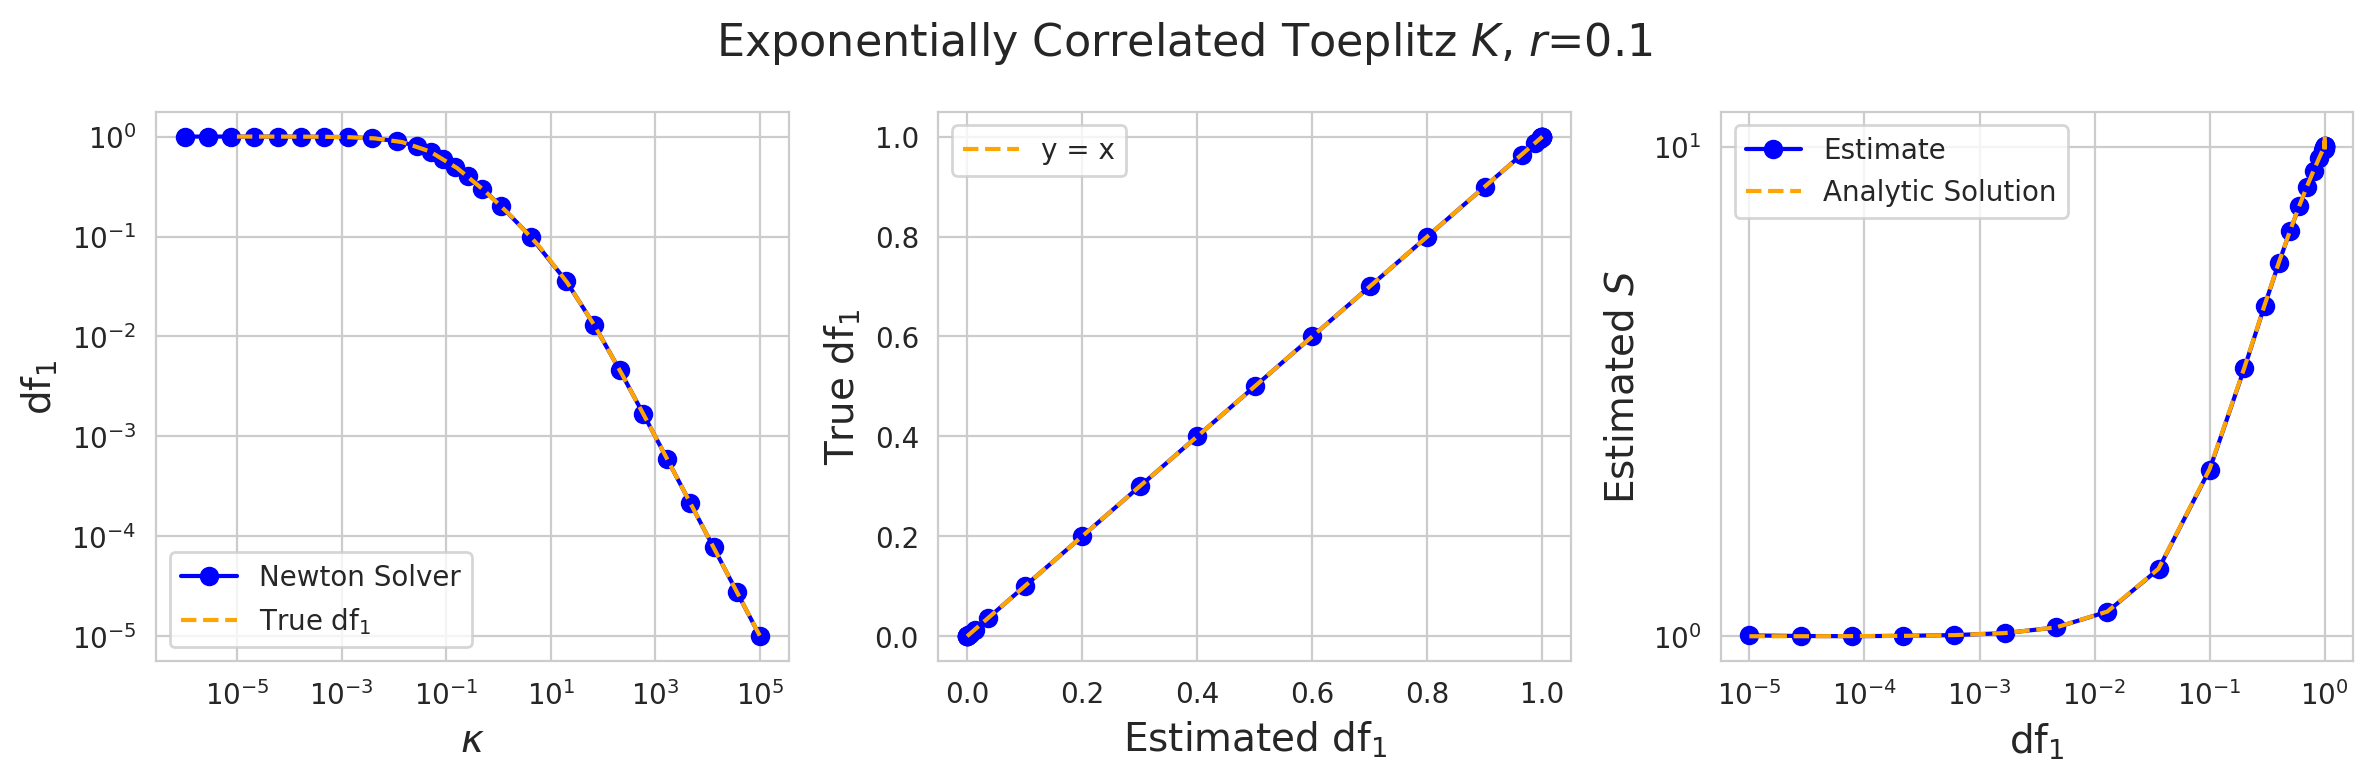

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(hspace=0.4)
fig.suptitle(f'Exponentially Correlated Toeplitz $K$, $r$={r}', fontsize=16)

ax[0].plot(kappa_solns, df1s, 'o-', color='blue', label='Newton Solver')
ax[0].plot(kappas, [df1_fn(kappa) for kappa in kappas], '--', color='orange', label='True df$_1$')
ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('$\\kappa$', fontsize=14)
ax[0].set_ylabel('df$_1$', fontsize=14)

ax[1].plot([df1_fn(kappa) for kappa in kappa_solns], df1s, color='b', ls='-', marker='o')
ax[1].plot(df1s, df1s, '--', color='orange', label='y = x')
ax[1].legend()
ax[1].set_xlabel('Estimated df$_1$', fontsize=14)
ax[1].set_ylabel('True df$_1$', fontsize=14)

S_fn = lambda df1: S_exp_corr(1/np.tanh(r), df1)
ax[2].plot(df1s, S_solns, color='b', ls='-', marker='o', label="Estimate")
ax[2].plot(df1s, [S_fn(df1) for df1 in df1s], '--', color='orange', label="Analytic Solution")
ax[2].legend()
ax[2].set_xlabel('df$_1$', fontsize=14)
ax[2].set_ylabel('Estimated $S$', fontsize=14)
ax[2].set_xscale('log')
ax[2].set_yscale('log')

plt.tight_layout()

In [ ]:
T = 50
N = 500
q = N/T
r = 1e-2
b = 1/np.tanh(r)
alpha = 0.0

# The ways we'll color the covariance on both sides
K = toeplitz(np.exp(-r*np.arange(T)))
spectrum_S = np.arange(1, N+1)**(-alpha)
Sigma = np.diag(spectrum_S)
spectrum_K = np.linalg.eigvalsh(np.array(K, dtype=np.float64))[::-1]

# Define the empirical covariance
Z = np.random.normal(size=(T, N))
Sh = jnp.sqrt(Sigma) @ (Z.T @ K @ Z) @ jnp.sqrt(Sigma) / T
Xh = jnp.linalg.cholesky(K) @ Z @ jnp.sqrt(Sigma) / np.sqrt(T)

_, spectrum_Sh_svd, _ = np.linalg.svd(Xh)
spectrum_Sh_svd = spectrum_Sh_svd**2

spectrum_Sh = jnp.linalg.eigvalsh(np.array(Sh, dtype=np.float64))[::-1]
if N > T:
    spectrum_Sh = jnp.concatenate([spectrum_Sh[:T], jnp.zeros(N - T)])
    spectrum_Kh = spectrum_Sh[:T]
    spectrum_Sh_svd = jnp.concatenate([spectrum_Sh_svd[:T], jnp.zeros(N - T)])
    spectrum_Kh_svd = spectrum_Sh_svd[:T]
else:
    spectrum_Kh = jnp.concatenate([spectrum_Sh, jnp.zeros(T - N)])
    spectrum_Kh_svd = jnp.concatenate([spectrum_Sh_svd, jnp.zeros(T - N)])

df1_fn_K = lambda k: df_1(spectrum_K, k)
df1_fn_S = lambda k: df_1(spectrum_S, k)
df1_fn_Sh = lambda lamb: df_1(spectrum_Sh, lamb)
df1_fn_Kh = lambda lamb: q*df_1(spectrum_Sh, lamb)

# Range of df1 for which we'll find the corresponding lambda, kappa, tilde kappa
df1s = np.concatenate((np.logspace(-5, -1, 10), np.linspace(0.2, 0.8, 7), 1-np.logspace(-5, -1, 10)[::-1]))
if q > 1:
    df1s = df1s * 1/q

S_fn = lambda df1: 1/(1-q*df1) * S_exp_corr(b, q * df1)

l_solns, k1_solns, S1_solns, k2_solns, S2_solns = [], [], [], [], []
for df1 in df1s:
    l = get_kappa(df1_fn_Sh, df1, lower=1e-10, upper=1e8, max_step=250, abs_tol=1e-9)
    k1 = get_kappa(df1_fn_S, df1, lower=1e-10, upper=1e8, max_step=250, abs_tol=1e-9)
    k2 = get_kappa(df1_fn_K, q*df1, lower=1e-10, upper=1e8, max_step=250, abs_tol=1e-9)
    l_solns += [l]
    k1_solns += [k1]
    k2_solns += [k2]
    S1_solns += [k1/l]
    S2_solns += [k2/l]
l_solns = np.array(l_solns)
k1_solns = np.array(k1_solns)
k2_solns = np.array(k2_solns)
S1_solns = np.array(S1_solns)
S2_solns = np.array(S2_solns)

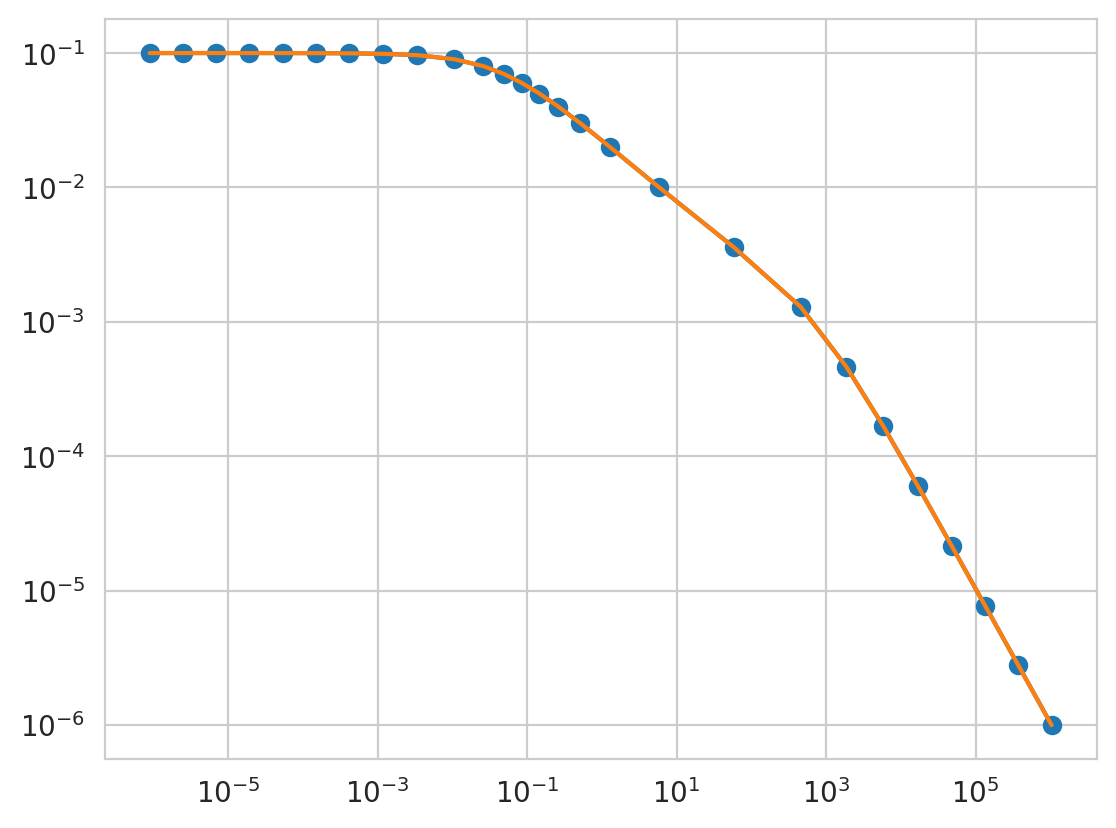

In [ ]:
plt.loglog(l_solns, [df1_fn_Sh(l) for l in l_solns], 'o-')
plt.loglog(l_solns, [df1_fn_S(k) for k in k1_solns])

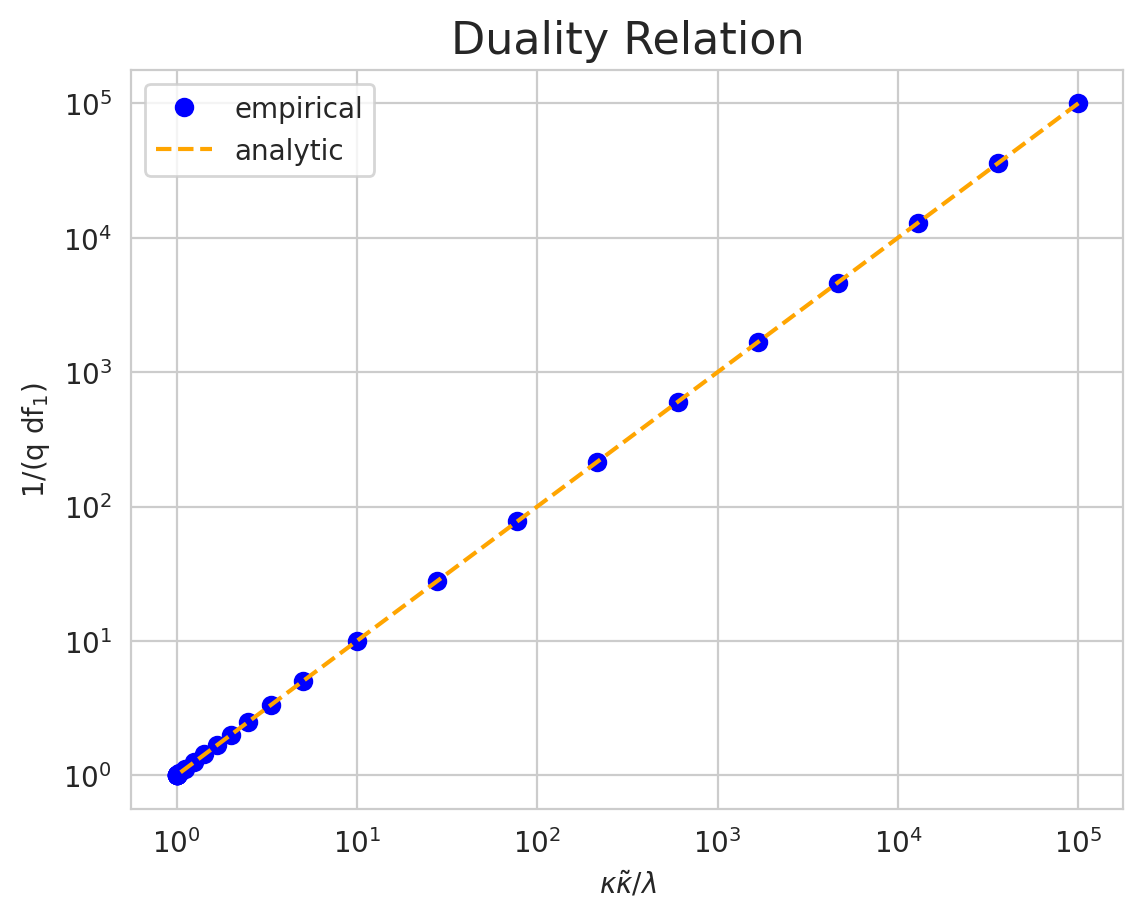

In [ ]:
plt.title("Duality Relation", fontsize=16)
plt.plot(1/(q*df1s), k1_solns*k2_solns/l_solns, 'o', color='blue', label='empirical')
plt.plot(1/(q*df1s), 1/(q*df1s), '--', color='orange', label='analytic')
plt.xlabel("$\\kappa \\tilde \\kappa / \\lambda$")
plt.ylabel("1/(q df$_1$)")
plt.xscale('log')
plt.yscale('log')
plt.legend()

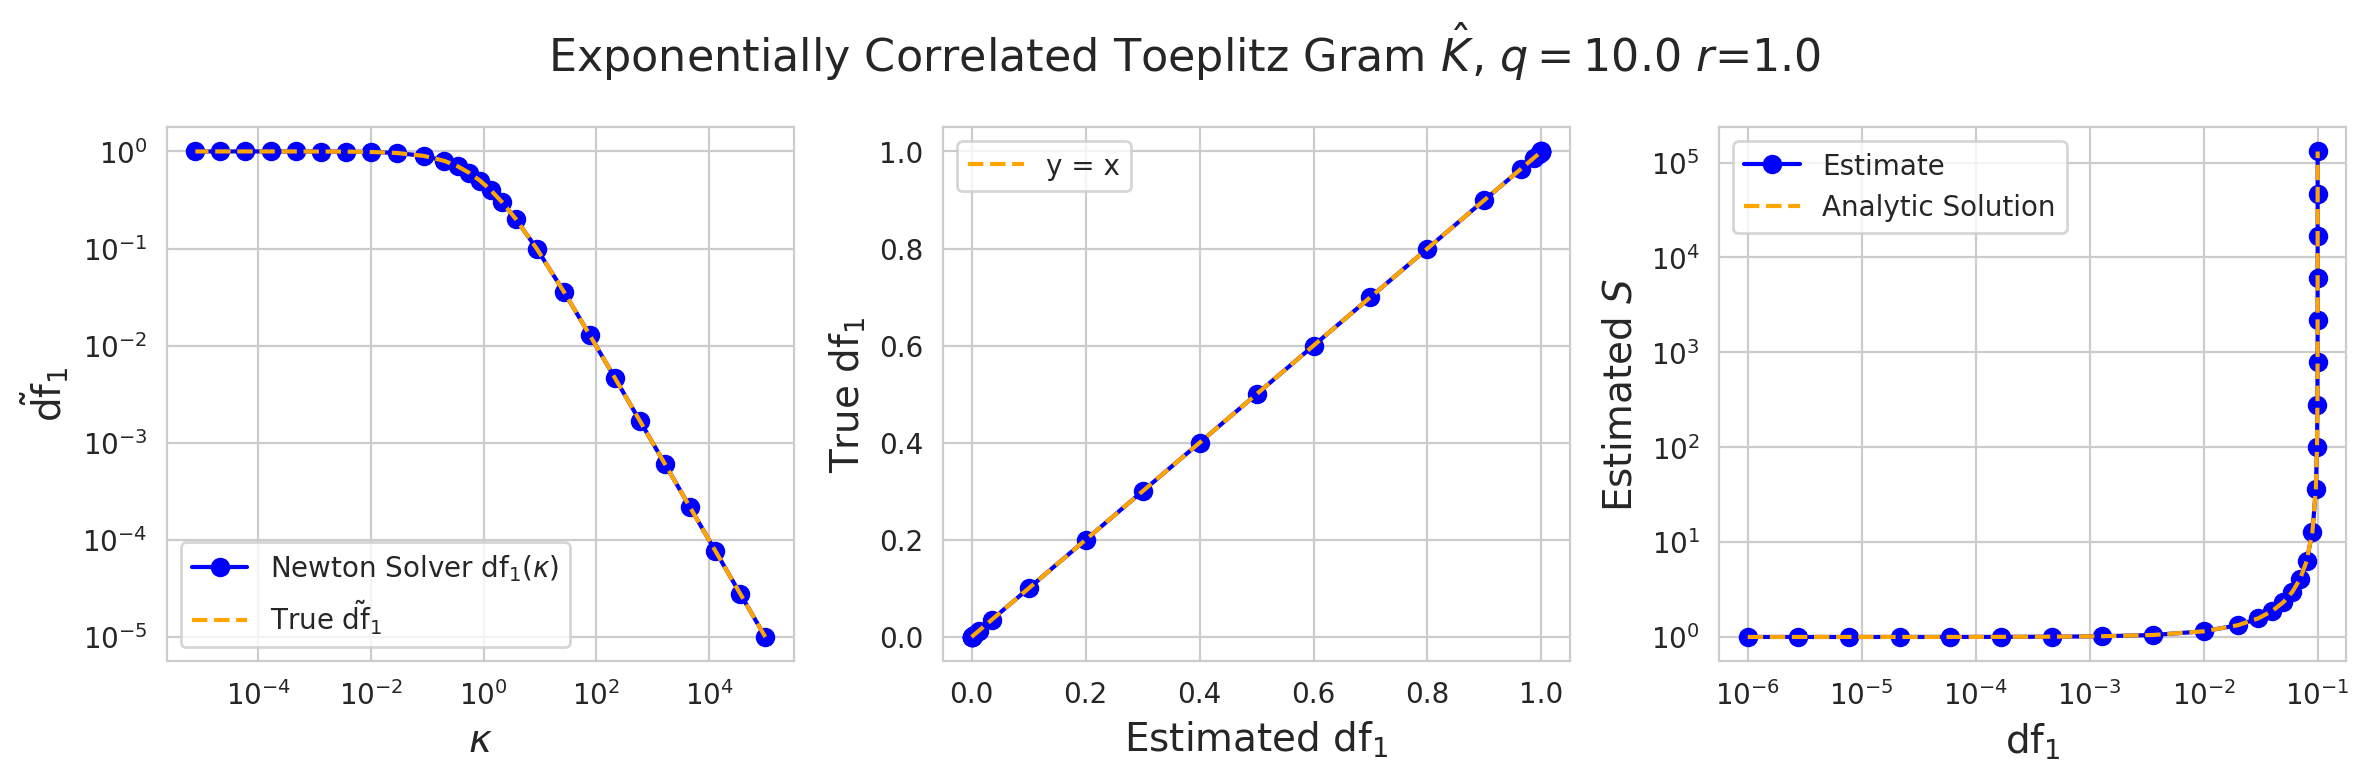

In [ ]:
# 2 x 1 subplot grid:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(hspace=0.4)

# Global title:
fig.suptitle(f'Exponentially Correlated Toeplitz Gram $\\hat K$, $q=${q} $r$={r}', fontsize=16)

ax[0].plot(k2_solns, q*df1s, 'o-', color='blue', label='Newton Solver df$_1(\\kappa)$')
ax[0].plot(k2_solns, [df1_fn_K(k) for k in k2_solns], '--', color='orange', label='True $\\tilde \\mathrm{df}_1$')
ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('$\\kappa$', fontsize=14)
ax[0].set_ylabel('$\\tilde \\mathrm{df}_1$', fontsize=14)

ax[1].plot([df1_fn_K(k) for k in k2_solns], q*df1s, color='b', ls='-', marker='o')
ax[1].plot(q*df1s, q*df1s, '--', color='orange', label='y = x')
ax[1].legend()
ax[1].set_xlabel('Estimated df$_1$', fontsize=14)
ax[1].set_ylabel('True df$_1$', fontsize=14)

ax[2].plot(df1s, S1_solns, color='b', ls='-', marker='o', label="Estimate")
ax[2].plot(df1s, [S_fn(df1) for df1 in df1s], '--', color='orange', label="Analytic Solution")
ax[2].legend()
ax[2].set_xlabel('df$_1$', fontsize=14)
ax[2].set_ylabel('Estimated $S$', fontsize=14)
ax[2].set_xscale('log')
ax[2].set_yscale('log')

plt.tight_layout()

In [ ]:
d_df1_fn_Kh = grad(df1_fn_Kh) # lambda l: -df_1p(spectrum_Kh, l)
d_df1_fn_Sh = grad(df1_fn_Sh) # lambda l: -df_1p(spectrum_Sh, l)
# lambda l: max(-1/(q*(q-1)),

k1_fn = lambda lamb: lamb * 1/(1-q*df1_fn_Sh(lamb)) * S_exp_corr(b, q*df1_fn_Sh(lamb))
log_k1_fn = lambda lamb: jnp.log(k1_fn(lamb))
d_k1_fn = grad(k1_fn)
d_log_k1_fn = grad(log_k1_fn)

k2_fn = lambda lamb: lamb * 1/(q-q*df1_fn_Sh(lamb))
log_k2_fn = lambda lamb: jnp.log(k2_fn(lamb))
d_k2_fn = grad(k2_fn)
d_log_k2_fn = grad(log_k2_fn)

l_fn = lambda kappa: kappa * (q-df1_fn_K(kappa))
d_l_fn = grad(l_fn)


df2_fn_Sh = get_df2_fn(df1_fn_Sh, lambda df: 1/(1-q*df)* S_exp_corr(b, q*df))
df2_fn_Kh = get_df2_fn(df1_fn_Kh, lambda df: 1/(q-df))

df2_fn_S = lambda kappa: df_2(spectrum_S, kappa)
df2_fn_K = lambda kappa: df_2(spectrum_K, kappa)

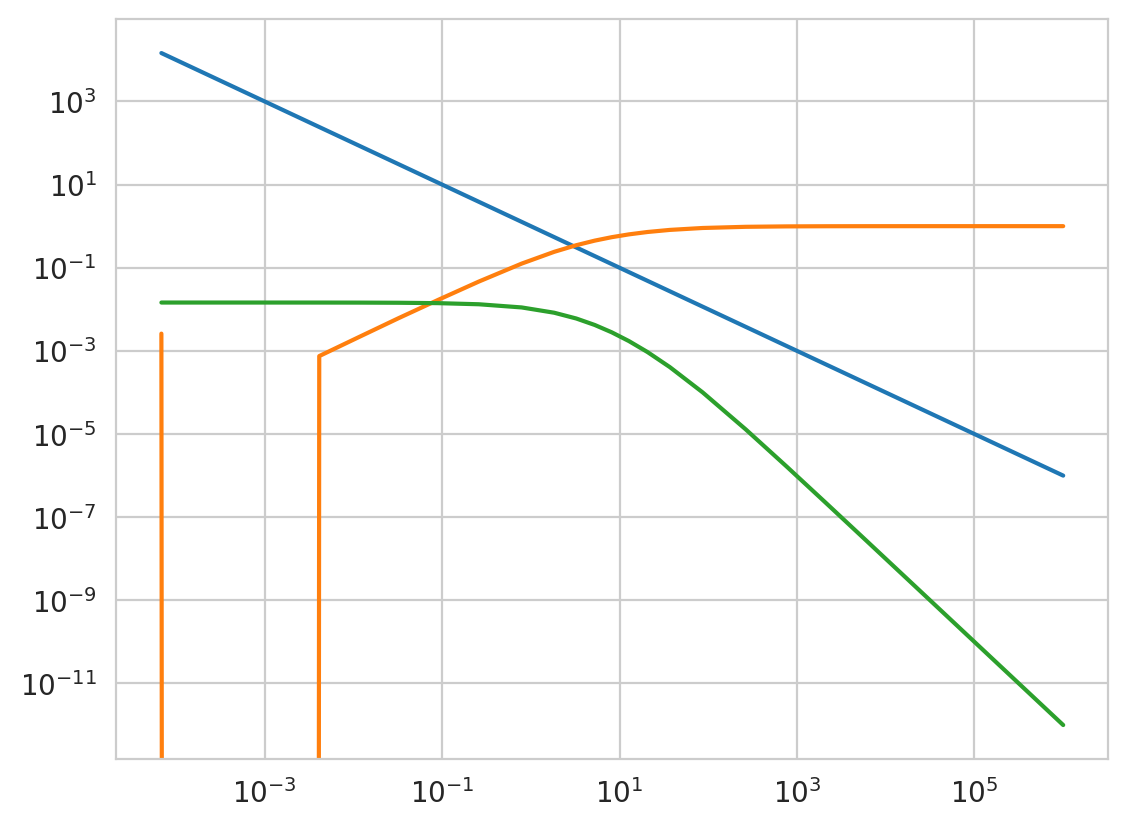

In [ ]:
# plt.loglog(l_solns, [l*d_log_k1_fn(l) for l in l_solns])
plt.loglog(l_solns, [1/l for l, df1 in zip(l_solns, df1s)])
plt.loglog(l_solns, [1+ q*l/(1-q*df1) * d_df1_fn_Sh(l) for l,k, df1 in zip(l_solns,k1_solns, df1s)])
plt.loglog(l_solns, [-d_df1_fn_Sh(l) for l,k, df1 in zip(l_solns,k1_solns, df1s)])

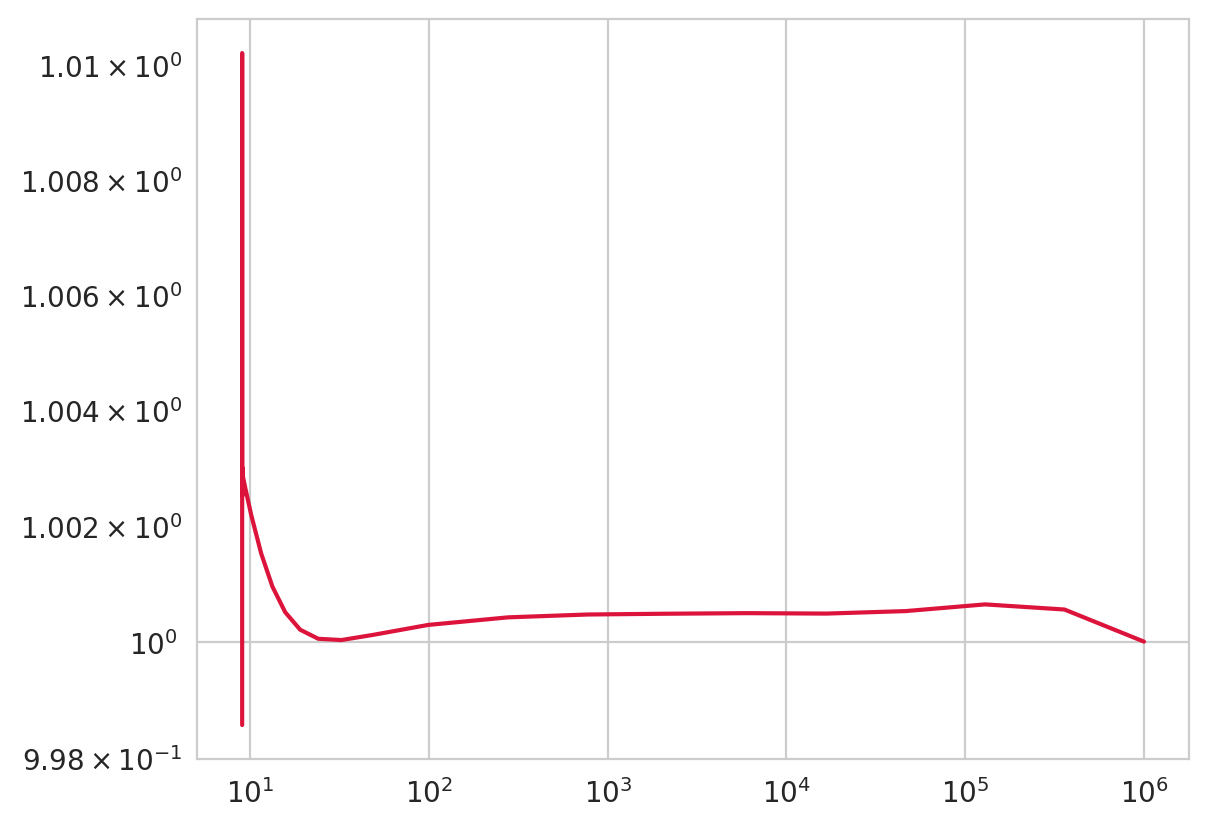

In [ ]:
# plt.loglog(l_solns, [k1_fn(l)-(q-1) for l in l_solns], '-', color='crimson', label='$\\kappa$')
plt.loglog(k1_solns, np.abs([l/(1-q*df)*S_exp_corr(b, q*df) for l,k, df in zip(l_solns, k1_solns,df1s)]/ k1_solns), '-', color='crimson', label='$\\kappa$')

All the issue comes from this d log k1 / d lambda

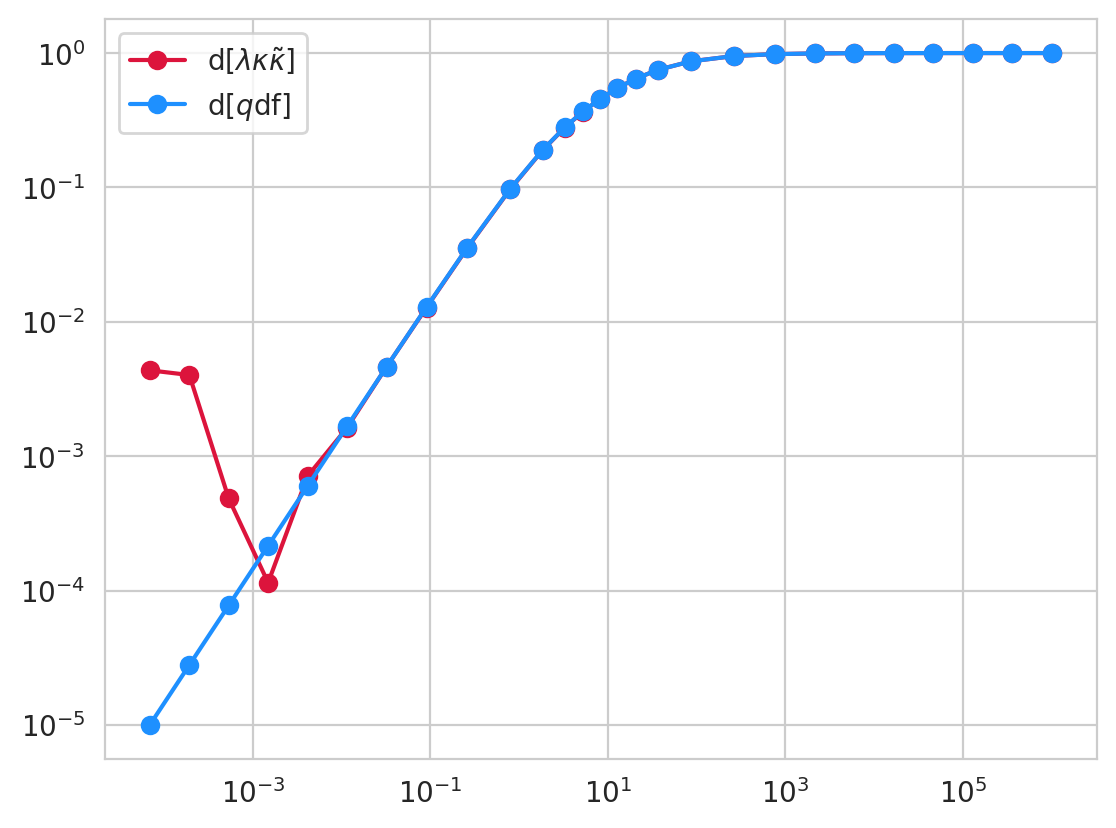

In [ ]:
plt.loglog(l_solns, [-(1 - l*d_log_k1_fn(l) - l*d_log_k2_fn(l)) for l in l_solns], 'o-', color='crimson', label="d[$\\lambda \\kappa \\tilde \\kappa$]")
plt.loglog(l_solns, [-l*d_df1_fn_Sh(l)/df1_fn_Sh(l) for l in l_solns], 'o-', color='dodgerblue',  label="d[$q$df]")
plt.legend()

Text(0.5, 0, '$\\lambda$')

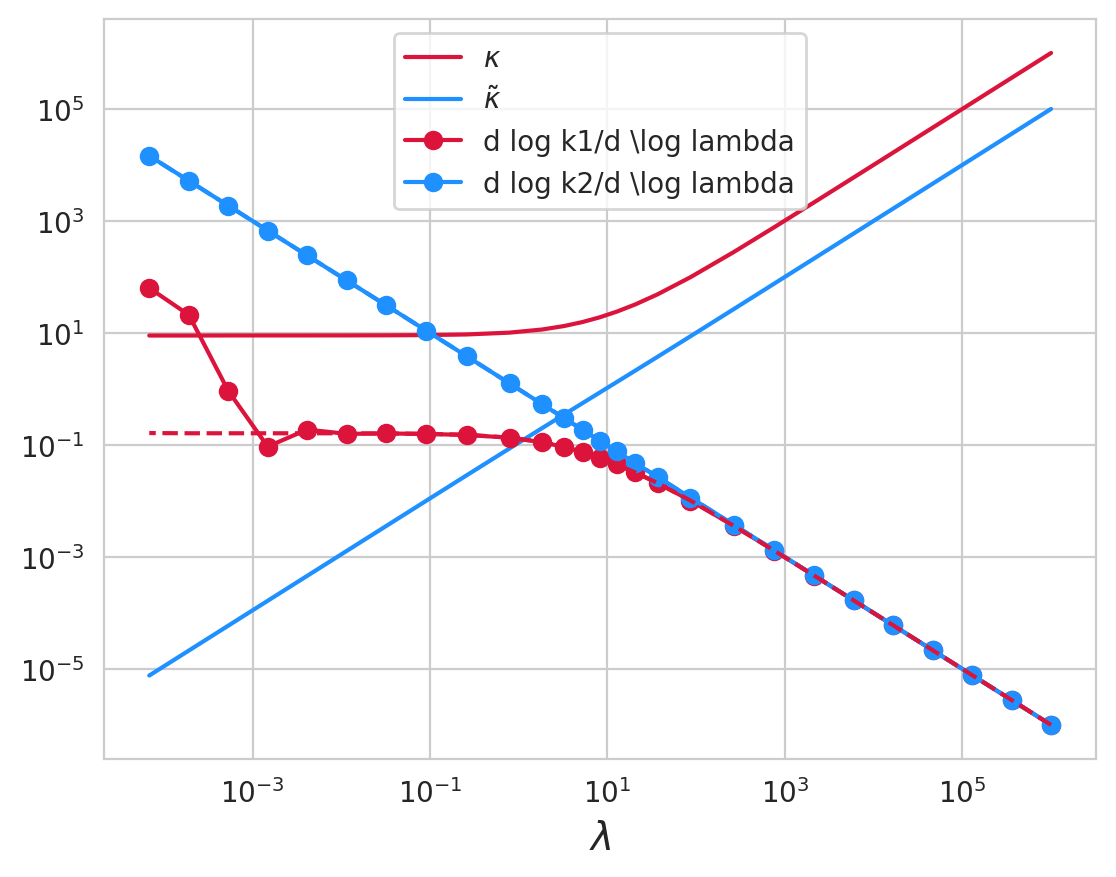

In [ ]:
# plt.semilogy([-d_df1_fn_Sh(lamb) for lamb in l_solns], 'o-', label='d df1/d lambda')
plt.loglog(l_solns, [k1_fn(l) for l in l_solns], '-', color='crimson', label='$\\kappa$')
plt.loglog(l_solns, [k2_fn(l) for l in l_solns], '-', color='dodgerblue', label='$\\tilde \\kappa$')
plt.loglog(l_solns, [d_log_k1_fn(l) for l in l_solns], 'o-', color='crimson', label='d log k1/d \\log lambda')
plt.loglog(l_solns, [d_log_k2_fn(l) for l in l_solns], 'o-', color='dodgerblue', label='d log k2/d \\log lambda')
plt.loglog(l_solns, [1/l - d_df1_fn_Sh(l)/df1_fn_Sh(l) - d_log_k1_fn(l) for l in l_solns], '--', color='dodgerblue')
plt.loglog(l_solns, [1/l - d_df1_fn_Sh(l)/df1_fn_Sh(l) - d_log_k2_fn(l) for l in l_solns], '--', color='crimson')
# plt.loglog(l_solns, [S_exp_corr(b, q*df1_fn_Sh(lamb)) for lamb in l_solns], 'o-', color='green', label='S')
plt.legend()
plt.xlabel("$\\lambda$", fontsize=14)

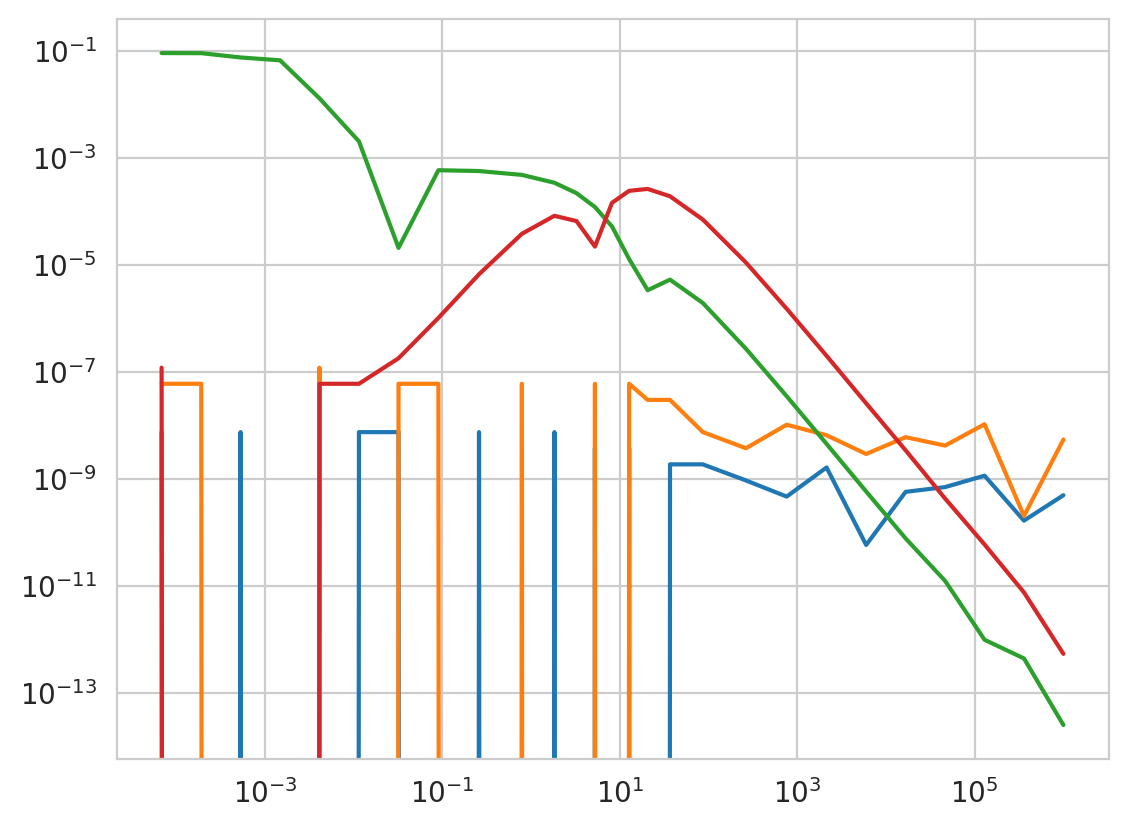

In [ ]:
plt.loglog(l_solns, np.abs([df1_fn_Sh(l)-df1_fn_S(k)  for l,k  in zip(l_solns, k1_solns)]))
plt.plot(l_solns, np.abs([df1_fn_Kh(l)-df1_fn_K(k)  for l,k  in zip(l_solns, k2_solns)]))
plt.plot(l_solns, np.abs([df2_fn_Sh(l)-df2_fn_S(k)  for l,k  in zip(l_solns, k1_solns)]))
plt.plot(l_solns, np.abs([df2_fn_Kh(l)-df2_fn_K(k)  for l,k  in zip(l_solns, k2_solns)]))

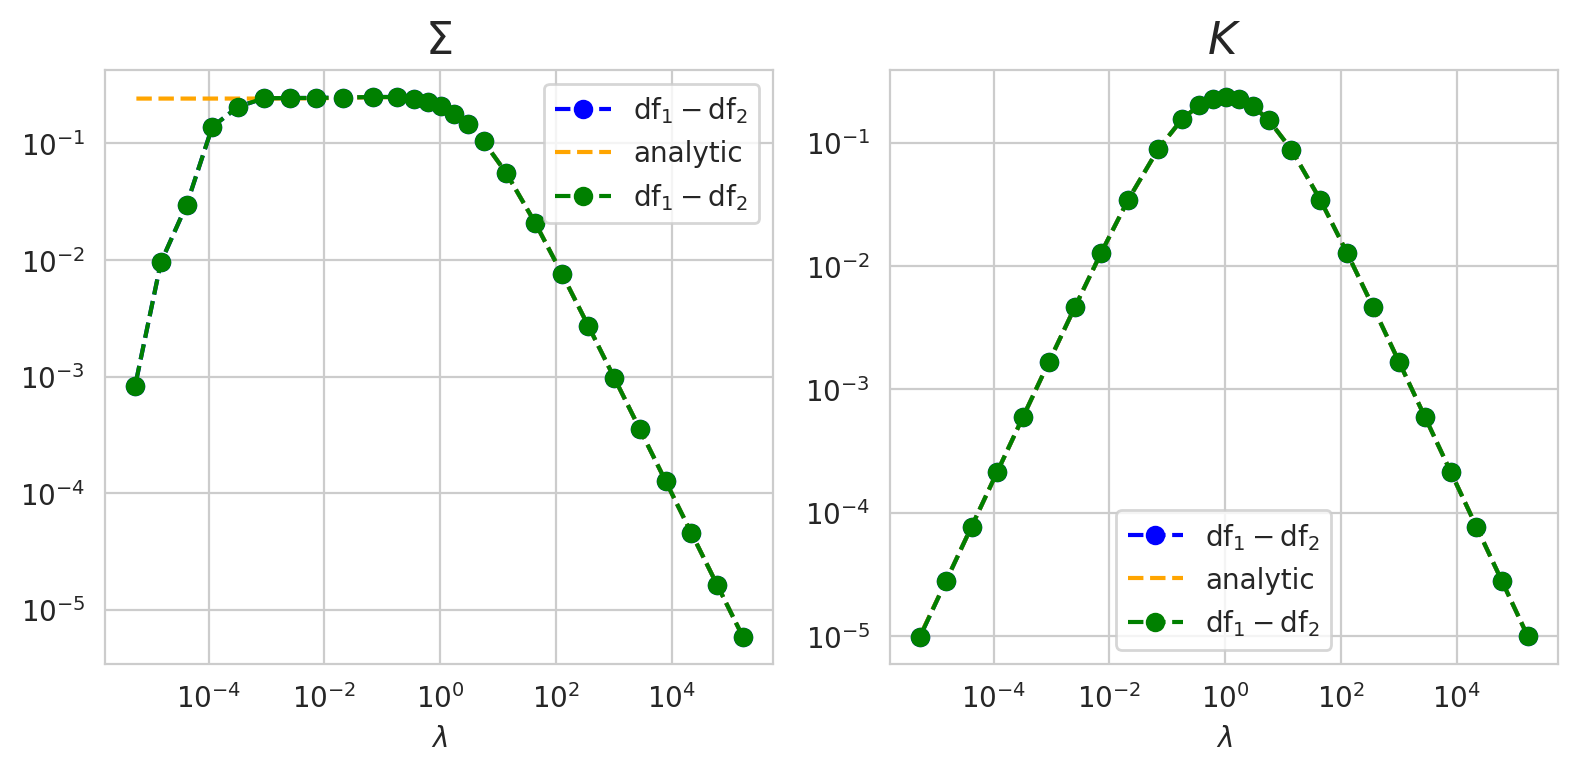

In [ ]:
# plt.loglog(k2_solns, [- (d_df1_fn_Kh(l))/(d_log_k2_fn(l)) for l, k2 in zip(l_solns, k2_solns)],
#            color='blue', marker='o', ls='-', label='$\\frac{{d \\log \\lambda}}{{d \\log \\kappa}}$')
# plt.loglog(k2_solns, [df1_fn_K(k2)- l*d_l_fn(k2)*k2/l * (-d_df1_fn_Kh(l)) for l, k2 in zip(l_solns, k2_solns)],
        #    color='forestgreen', marker='o', ls='-', label='$\\frac{{d \\log \\lambda}}{{d \\log \\kappa}}$')
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].loglog(l_solns, [df1_fn_Sh(l) - df2_fn_Sh(l) for l in l_solns],
            ls='--', marker='o', color='b', label='df$_1 - $df$_2$')
axs[0].loglog(l_solns, [df1_fn_S(k) - df2_fn_S(k) for k in k1_solns],
           color='orange', label='analytic', ls='--')
axs[0].loglog(l_solns, [1/q*(df1_fn_Kh(l) - df2_fn_Kh(l))*d_log_k2_fn(l)/d_log_k1_fn(l) for l in l_solns],
            ls='--', marker='o', color='g', label='df$_1 - $df$_2$')
axs[0].title.set_text("$\\Sigma$")
axs[0].title.set_fontsize(16)

axs[0].set_xlabel("$\\lambda$")
axs[0].legend()

axs[1].loglog(l_solns, [df1_fn_Kh(l) - df2_fn_Kh(l) for l in l_solns],
            ls='--', marker='o', color='b', label='df$_1 - $df$_2$')
axs[1].loglog(l_solns, [df1_fn_K(k) - df2_fn_K(k) for k in k2_solns],
           color='orange', label='analytic', ls='--')
axs[1].loglog(l_solns, [q*(df1_fn_Sh(l) - df2_fn_Sh(l))*d_log_k1_fn(l)/d_log_k2_fn(l) for l in l_solns],
            ls='--', marker='o', color='g', label='df$_1 - $df$_2$')
axs[1].set_xlabel("$\\lambda$")
axs[1].legend()
axs[1].title.set_text("$K$")
axs[1].title.set_fontsize(16)

plt.tight_layout()



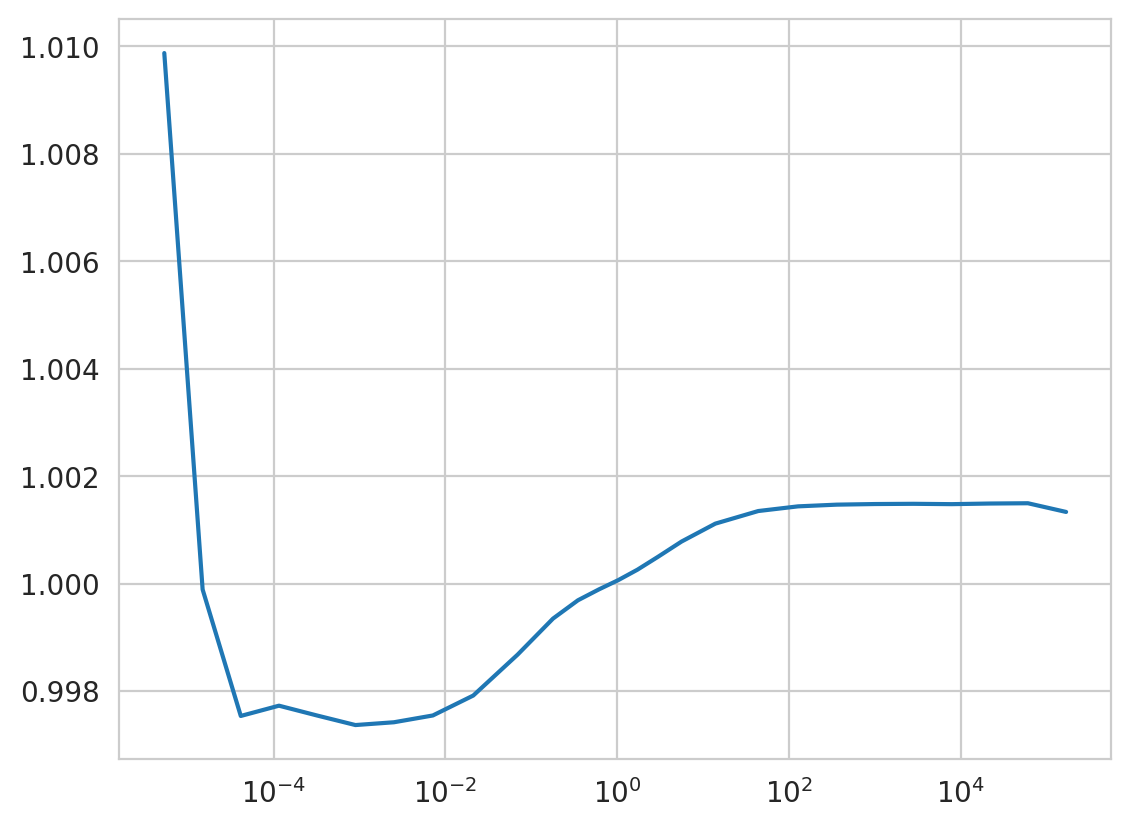

In [ ]:
plt.semilogx(l_solns, [k1*k2/l for k1, k2, l in zip(k1_solns, k2_solns, l_solns)]*(q*df1s))
# plt.loglog(l_solns, 1/(q*df1s))

Text(0.5, 1.0, 'The two GCVs')

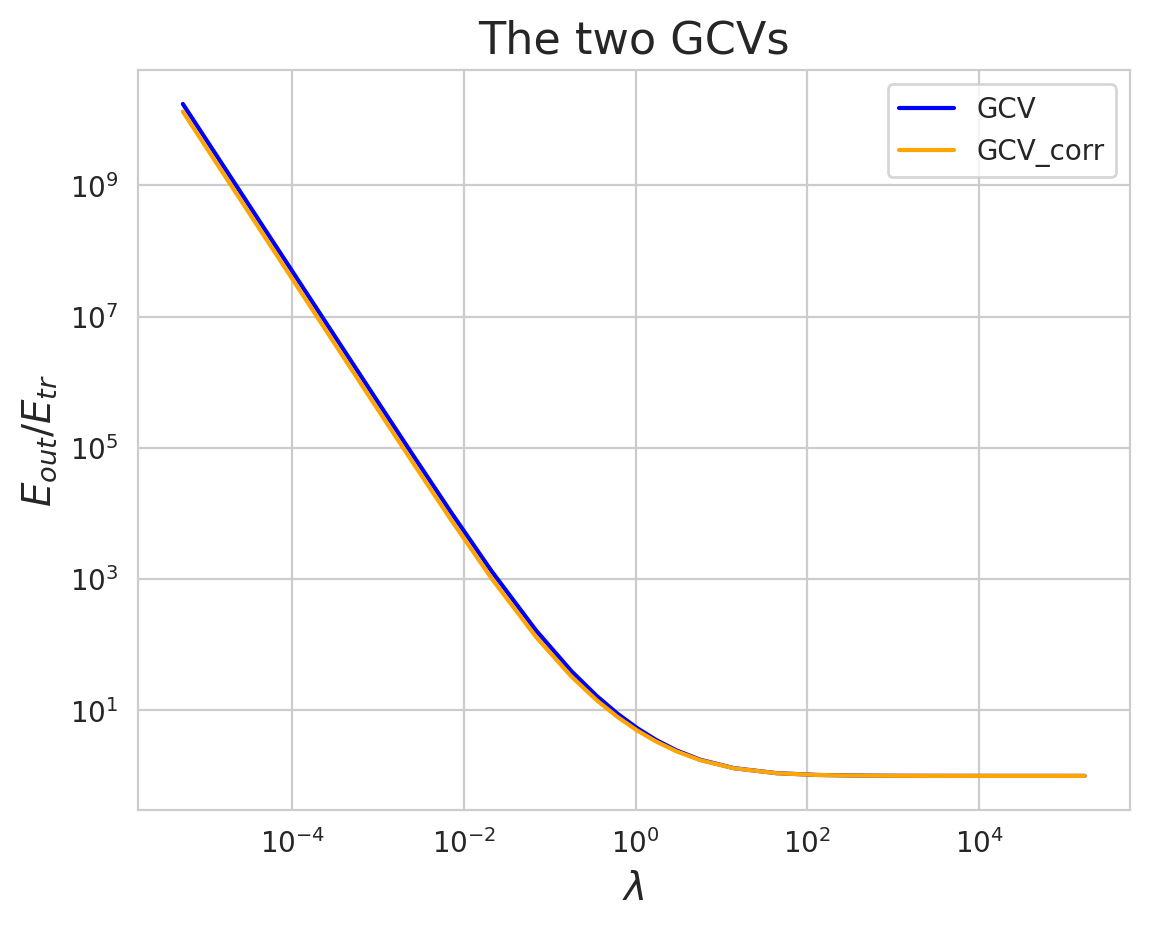

In [ ]:
GCV_correction = np.array([S1*(1-l*S1*S2*df2_fn_K(k2)) for l, S1, S2, k2 in zip(l_solns, S1_solns, S2_solns, k2_solns)])
GCV_std = np.array([S1**2 for l, S1, S2, k2 in zip(l_solns, S1_solns, S2_solns, k2_solns)])
GCV_corr = np.array([S1/(1-df2_fn_Kh(l)/(df1_fn_Kh(l))) for l, df1, S1, k2 in zip(l_solns, df1s, S1_solns, k2_solns)])
# GCV_corr2 = np.array([S1/(1-k2*S1*df2_fn_Kh(l)) for l, df1, S1, k2 in zip(l_solns, df1s, S1_solns, k2_solns)])
gamma_ratio = np.array([ (1/(q*df1))**2 * df2_fn_K(k2) for df1, l, k1, k2 in zip(df1s, l_solns, k1_solns, k2_solns)])
# plt.loglog(l_solns, gamma_ratio)
plt.plot(l_solns, GCV_std, label='GCV', color='b')
plt.loglog(l_solns, GCV_corr, label='GCV_corr', color='orange')
# plt.loglog(l_solns, GCV_corr2, label='GCV_corr', color='orange')
plt.legend()
plt.xlabel("$\\lambda$", fontsize=14)
plt.ylabel("$E_{{out}}/E_{{tr}}$", fontsize=14)
plt.title("The two GCVs", fontsize=16)


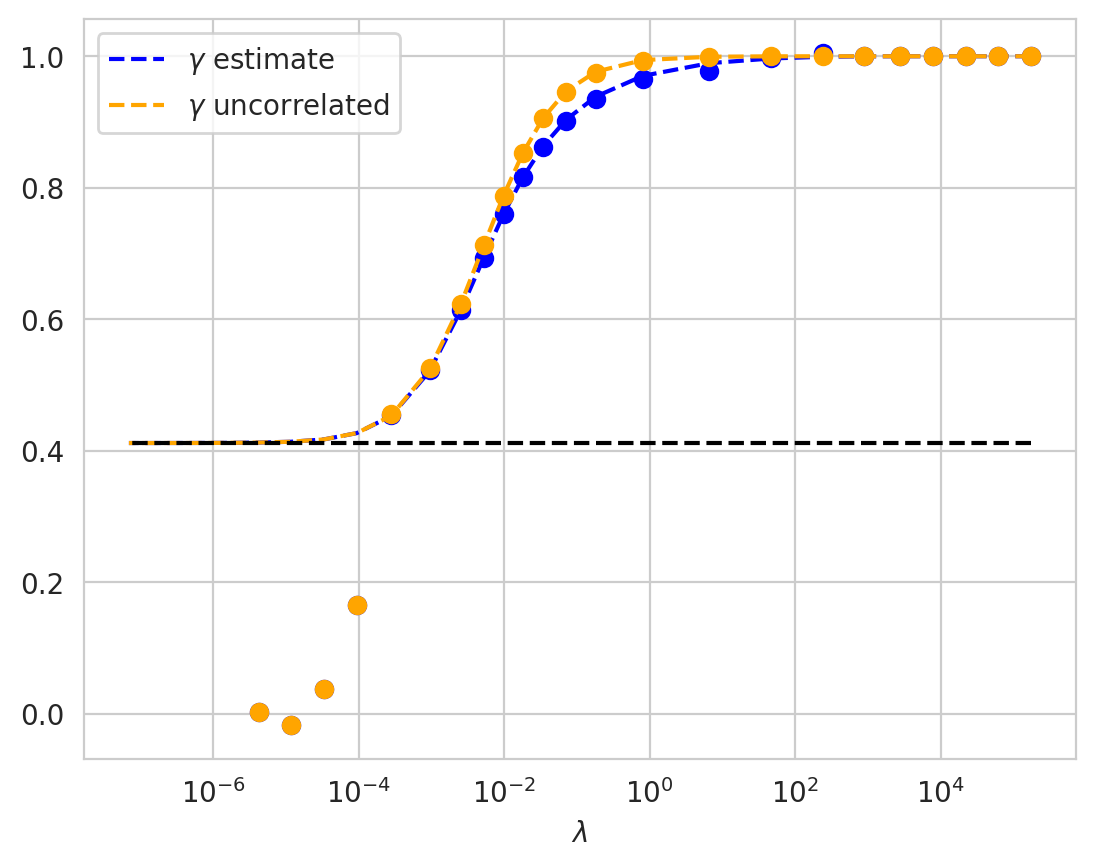

In [ ]:
gamma_est = [q * (1/(q*df1_fn_Sh(l)))**2 * df2_fn_Sh(l) * df2_fn_Kh(l) for df1, l, k1, k2 in zip(df1s, l_solns, k1_solns, k2_solns)]
gamma = [q * (1/(q*df1))**2 * df2_fn_S(k1) * df2_fn_K(k2) for df1, l, k1, k2 in zip(df1s, l_solns, k1_solns, k2_solns)]
gamma_uncorr_est = [q * df2_fn_Sh(l) for l in l_solns]
gamma_uncorr = [q * df2_fn_S(k1) for k1 in k1_solns]

plt.plot(l_solns, (1-np.array(gamma)), '--', color='blue', label='$\gamma$ estimate')
plt.plot(l_solns, (1-np.array(gamma_est)), marker='o', ls='', color='blue')

plt.plot(l_solns, (1-np.array(gamma_uncorr)), '--', color='orange', label='$\gamma$ uncorrelated')
plt.plot(l_solns, (1-np.array(gamma_uncorr_est)), marker='o', ls='', color='orange')

plt.plot(l_solns, k1_solns**(0.0) * (1-min(q, 1/q)), 'k--')

# plt.yscale('log')
plt.xscale('log')
plt.xlabel("$\\lambda$")
plt.legend()

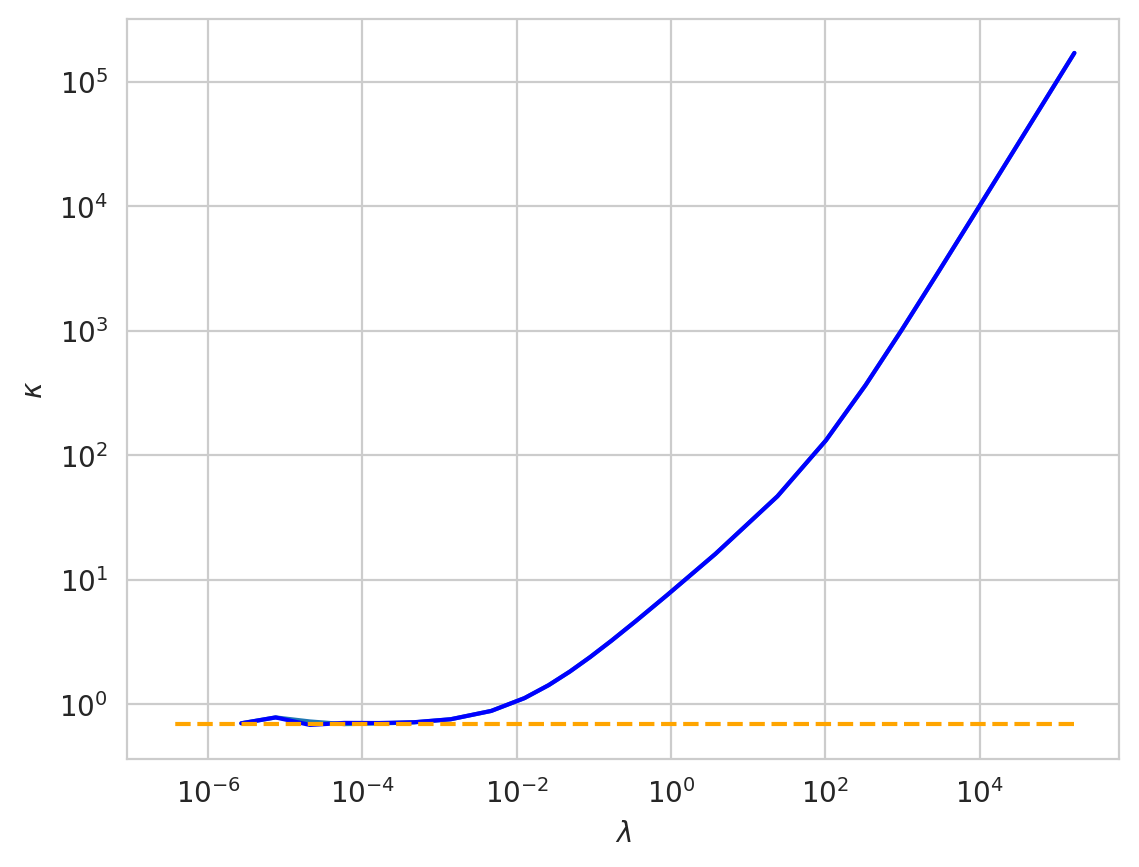

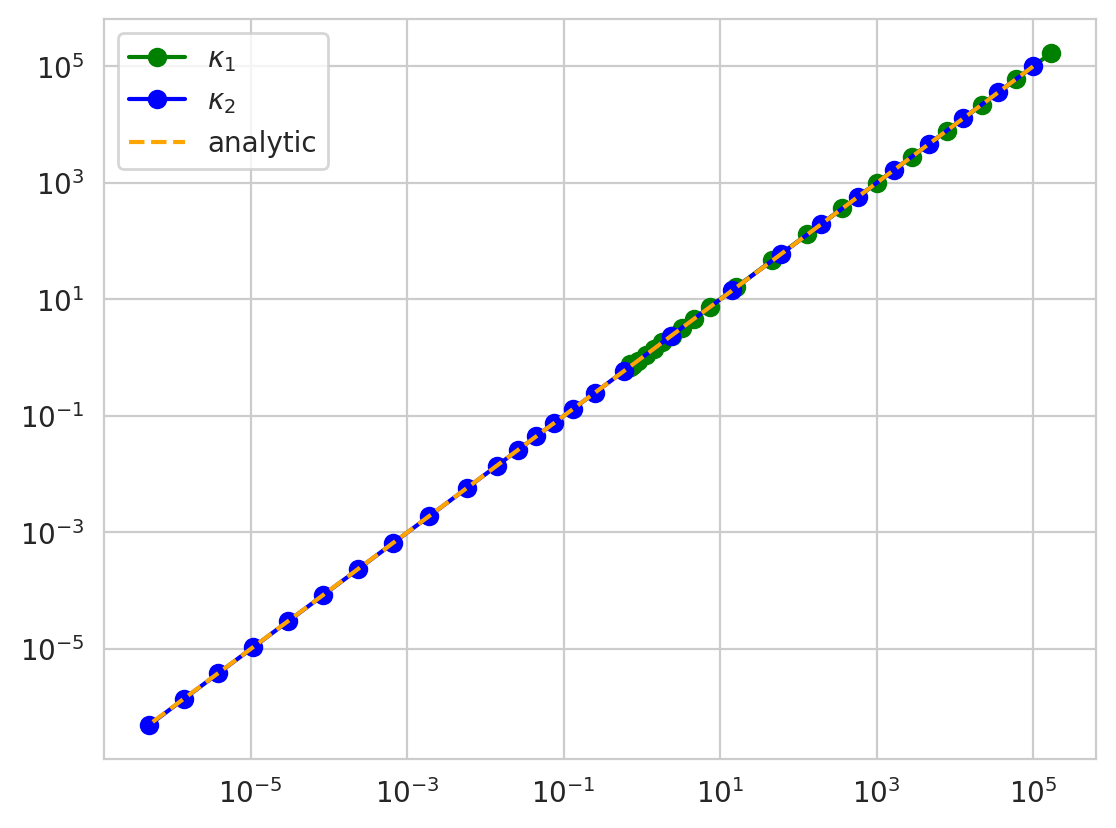

In [ ]:
plt.loglog(l_solns, [l/(1-q*df1_fn_Sh(l))* S_exp_corr(b, q*df1_fn_Sh(l)) for l in l_solns])
plt.loglog(l_solns, [l/(1-q*df)* S_exp_corr(b, q*df) for l,df in zip(l_solns, df1s)], color='blue')
plt.loglog(l_solns, (q-1)*l_solns**0.0 , '--', color='orange')
plt.xlabel('$\\lambda$')
plt.ylabel('$\\kappa$')
plt.show()

plt.loglog(k1_solns, [k1_fn(l) for l in l_solns], 'g', marker='o', label='$\\kappa_1$')
plt.loglog(k2_solns, [k2_fn(l) for l in l_solns], 'b', marker='o', label='$\\kappa_2$')
plt.plot(k2_solns, k2_solns, '--', color='orange', label='analytic')
plt.legend()

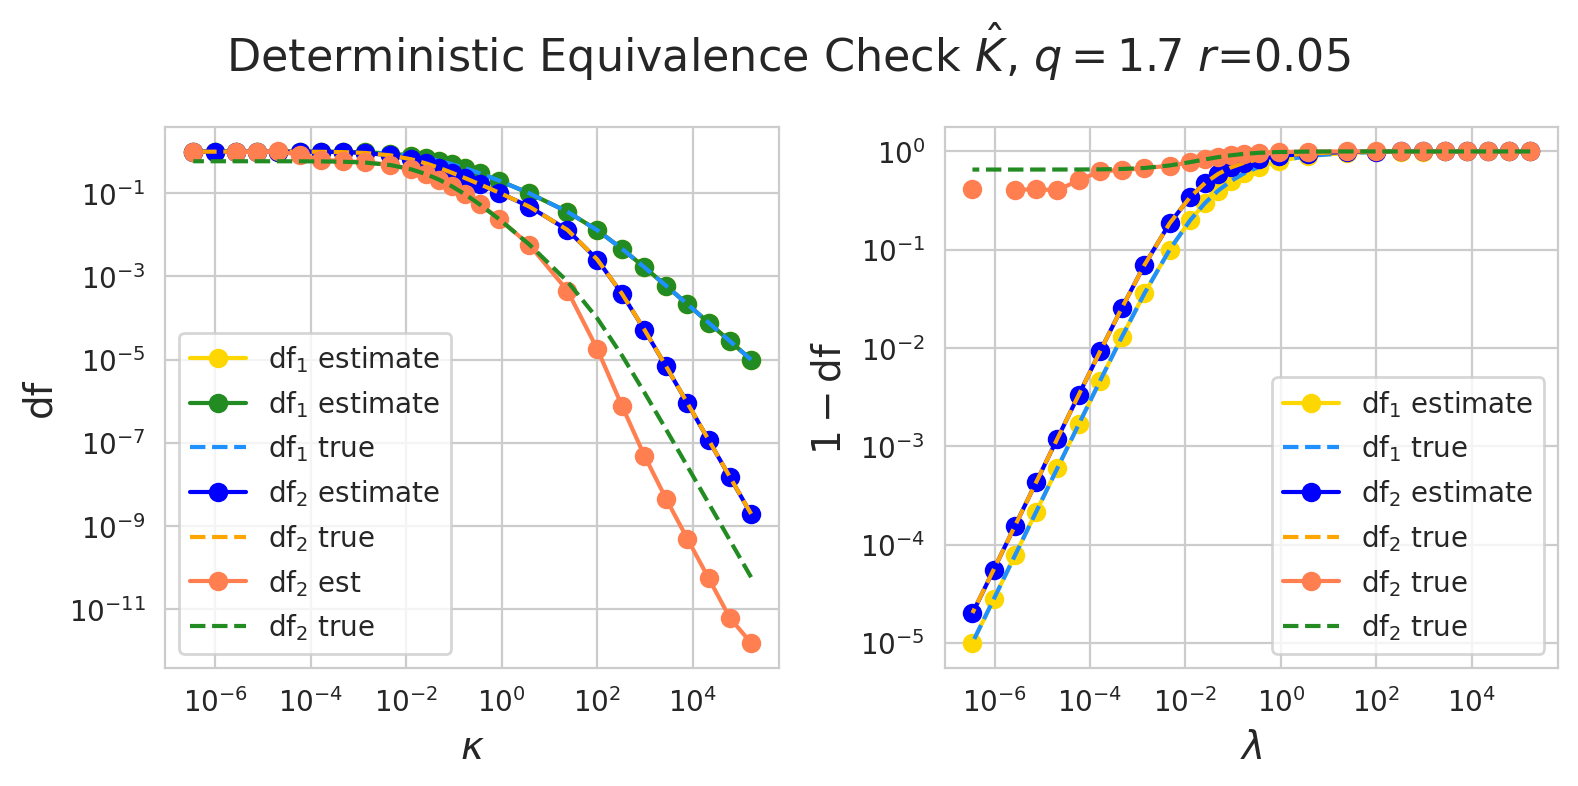

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.4)
fig.suptitle(f'Deterministic Equivalence Check $\\hat K$, $q=${q} $r$={r}', fontsize=16)

ax[0].loglog(l_solns, [df1_fn_Kh(lamb) for lamb in l_solns], color='gold', marker='o', ls='-', label="df$_1$ estimate")
ax[0].loglog(l_solns, [q*df1_fn_S(kappa) for kappa in k1_solns], color='forestgreen', marker='o', ls='-', label="df$_1$ estimate")
ax[0].loglog(l_solns, [df1_fn_K(kappa) for kappa in k2_solns], color='dodgerblue', ls='--', label="df$_1$ true")
ax[0].loglog(l_solns, [df2_fn_Kh(lamb) for lamb in l_solns], color='blue', marker='o', ls='-', label="df$_2$ estimate")
ax[0].loglog(l_solns, [df2_fn_K(kappa) for kappa in k2_solns], color='orange', ls='--', label="df$_2$ true")
ax[0].loglog(l_solns, [q*df2_fn_Sh(lamb) for lamb in l_solns], color='coral', marker='o', ls='-', label="df$_2$ est")
ax[0].loglog(l_solns, [q*df2_fn_S(kappa) for kappa in k1_solns], color='forestgreen', ls='--', label="df$_2$ true")

ax[0].set_xlabel("$\\kappa$", fontsize=14)
ax[0].set_ylabel("df", fontsize=14)
ax[0].legend()

ax[1].loglog(l_solns, [1-df1_fn_Kh(lamb) for lamb in l_solns], color='gold', marker='o', ls='-', label="df$_1$ estimate")
ax[1].loglog(l_solns, [1-df1_fn_K(kappa) for kappa in k2_solns], color='dodgerblue', ls='--', label="df$_1$ true")
ax[1].loglog(l_solns, [1-df2_fn_Kh(lamb) for lamb in l_solns], color='blue', marker='o', ls='-', label="df$_2$ estimate")
ax[1].loglog(l_solns, [1-df2_fn_K(kappa) for kappa in k2_solns], color='orange', ls='--', label="df$_2$ true")
ax[1].loglog(l_solns, [1-df2_fn_Sh(lamb) for lamb in l_solns], color='coral', marker='o', ls='-', label="df$_2$ true")
ax[1].loglog(l_solns, [1-df2_fn_S(kappa) for kappa in k1_solns], color='forestgreen', ls='--', label="df$_2$ true")



ax[1].set_xlabel("$\\lambda$", fontsize=14)
ax[1].set_ylabel("$1 - $df", fontsize=14)
ax[1].legend()

plt.tight_layout()

plt.show()


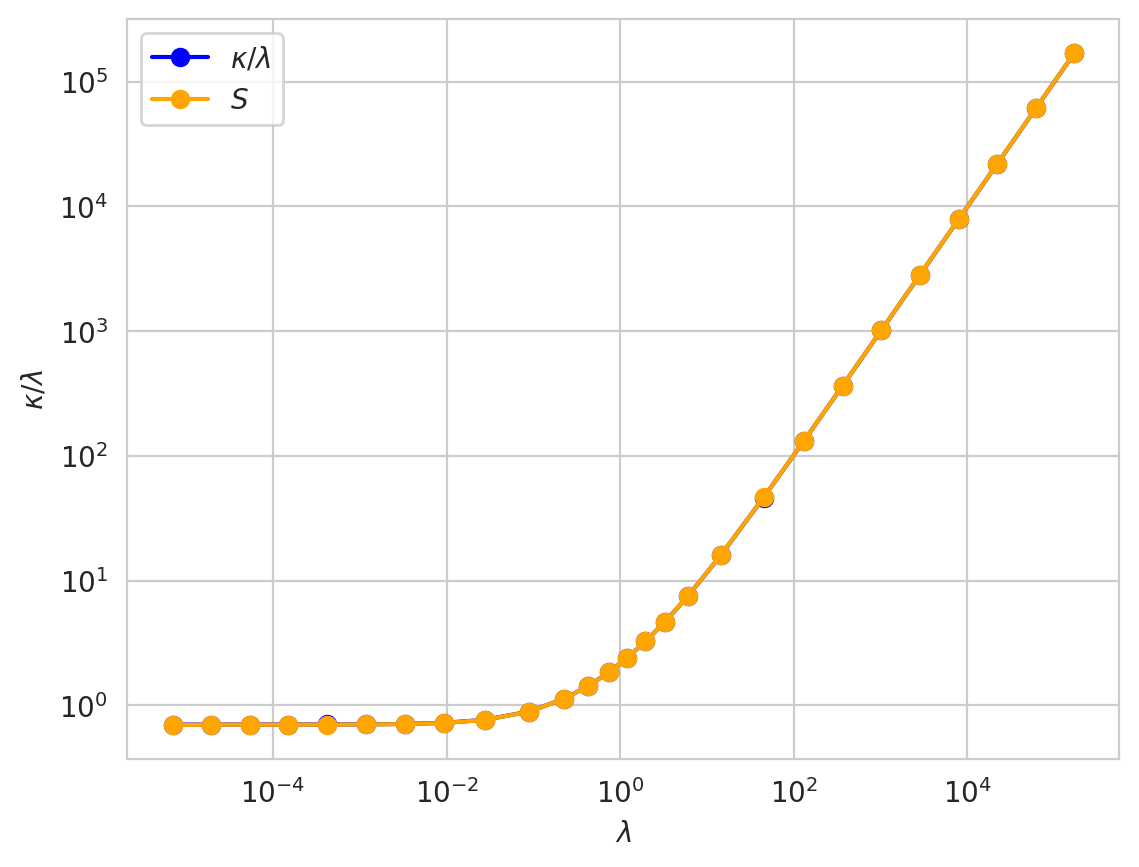

In [ ]:
plt.loglog(l_solns, k1_solns, color='blue', marker='o', ls='-', label="$\\kappa/\\lambda$")
plt.loglog(l_solns, l_solns/(1-q*df1s), color='orange', marker='o', ls='-', label="$S$")
plt.xlabel("$\\lambda$")
plt.ylabel("$\\kappa/\\lambda$")
plt.legend()

## Empirical $S$ Transforms

In [ ]:
T = 1000
N = 500
q = N/T
r = 1e-2
b = 1/np.tanh(r)
alpha = 0.0

# The ways we'll color the covariance on both sides
# K = toeplitz(np.exp(-r*np.arange(T)))
K = toeplitz(np.arange(1, T+1)**(-1.5) )
spectrum_S = np.arange(1, N+1)**(-alpha)
Sigma = np.diag(spectrum_S)
spectrum_K = np.linalg.eigvalsh(np.array(K, dtype=np.float64))[::-1]

# Define the empirical covariance
Z = np.random.normal(size=(T, N))
Sh = jnp.sqrt(Sigma) @ (Z.T @ K @ Z) @ jnp.sqrt(Sigma) / T
Xh = jnp.linalg.cholesky(K) @ Z @ jnp.sqrt(Sigma) / np.sqrt(T)

_, spectrum_Sh_svd, _ = np.linalg.svd(Xh)
spectrum_Sh_svd = spectrum_Sh_svd**2

spectrum_Sh = jnp.linalg.eigvalsh(np.array(Sh, dtype=np.float64))[::-1]
if N > T:
    spectrum_Sh = jnp.concatenate([spectrum_Sh[:T], jnp.zeros(N - T)])
    spectrum_Kh = spectrum_Sh[:T]
    spectrum_Sh_svd = jnp.concatenate([spectrum_Sh_svd[:T], jnp.zeros(N - T)])
    spectrum_Kh_svd = spectrum_Sh_svd[:T]
else:
    spectrum_Kh = jnp.concatenate([spectrum_Sh, jnp.zeros(T - N)])
    spectrum_Kh_svd = jnp.concatenate([spectrum_Sh_svd, jnp.zeros(T - N)])

df1_fn_K = lambda k: df_1(spectrum_K, k)
df1_fn_S = lambda k: df_1(spectrum_S, k)
df1_fn_Sh = lambda lamb: df_1(spectrum_Sh, lamb)
df1_fn_Kh = lambda lamb: q*df_1(spectrum_Sh, lamb)

# Range of df1 for which we'll find the corresponding lambda, kappa, tilde kappa
df1s = np.concatenate((np.logspace(-5, -1, 10), np.linspace(0.2, 0.8, 15), 1-np.logspace(-5, -1, 10)[::-1]))
# df1s = np.linspace(1e-4, 1-1e-5, 100)
if q > 1:
    df1s = df1s * 1/q

S_fn = lambda df1: 1/(1-q*df1) * S_exp_corr(b, q * df1)

l_solns, k1_solns, S1_solns, k2_solns, S2_solns = [], [], [], [], []
for df1 in df1s:
    l = get_kappa(df1_fn_Sh, df1, lower=1e-10, upper=1e8, max_step=250, abs_tol=1e-9)
    k1 = get_kappa(df1_fn_S, df1, lower=1e-10, upper=1e8, max_step=250, abs_tol=1e-9)
    k2 = get_kappa(df1_fn_K, q*df1, lower=1e-10, upper=1e8, max_step=250, abs_tol=1e-9)
    l_solns += [l]
    k1_solns += [k1]
    k2_solns += [k2]
    S1_solns += [k1/l]
    S2_solns += [k2/l]
l_solns = np.array(l_solns)
k1_solns = np.array(k1_solns)
k2_solns = np.array(k2_solns)
S1_solns = np.array(S1_solns)
S2_solns = np.array(S2_solns)

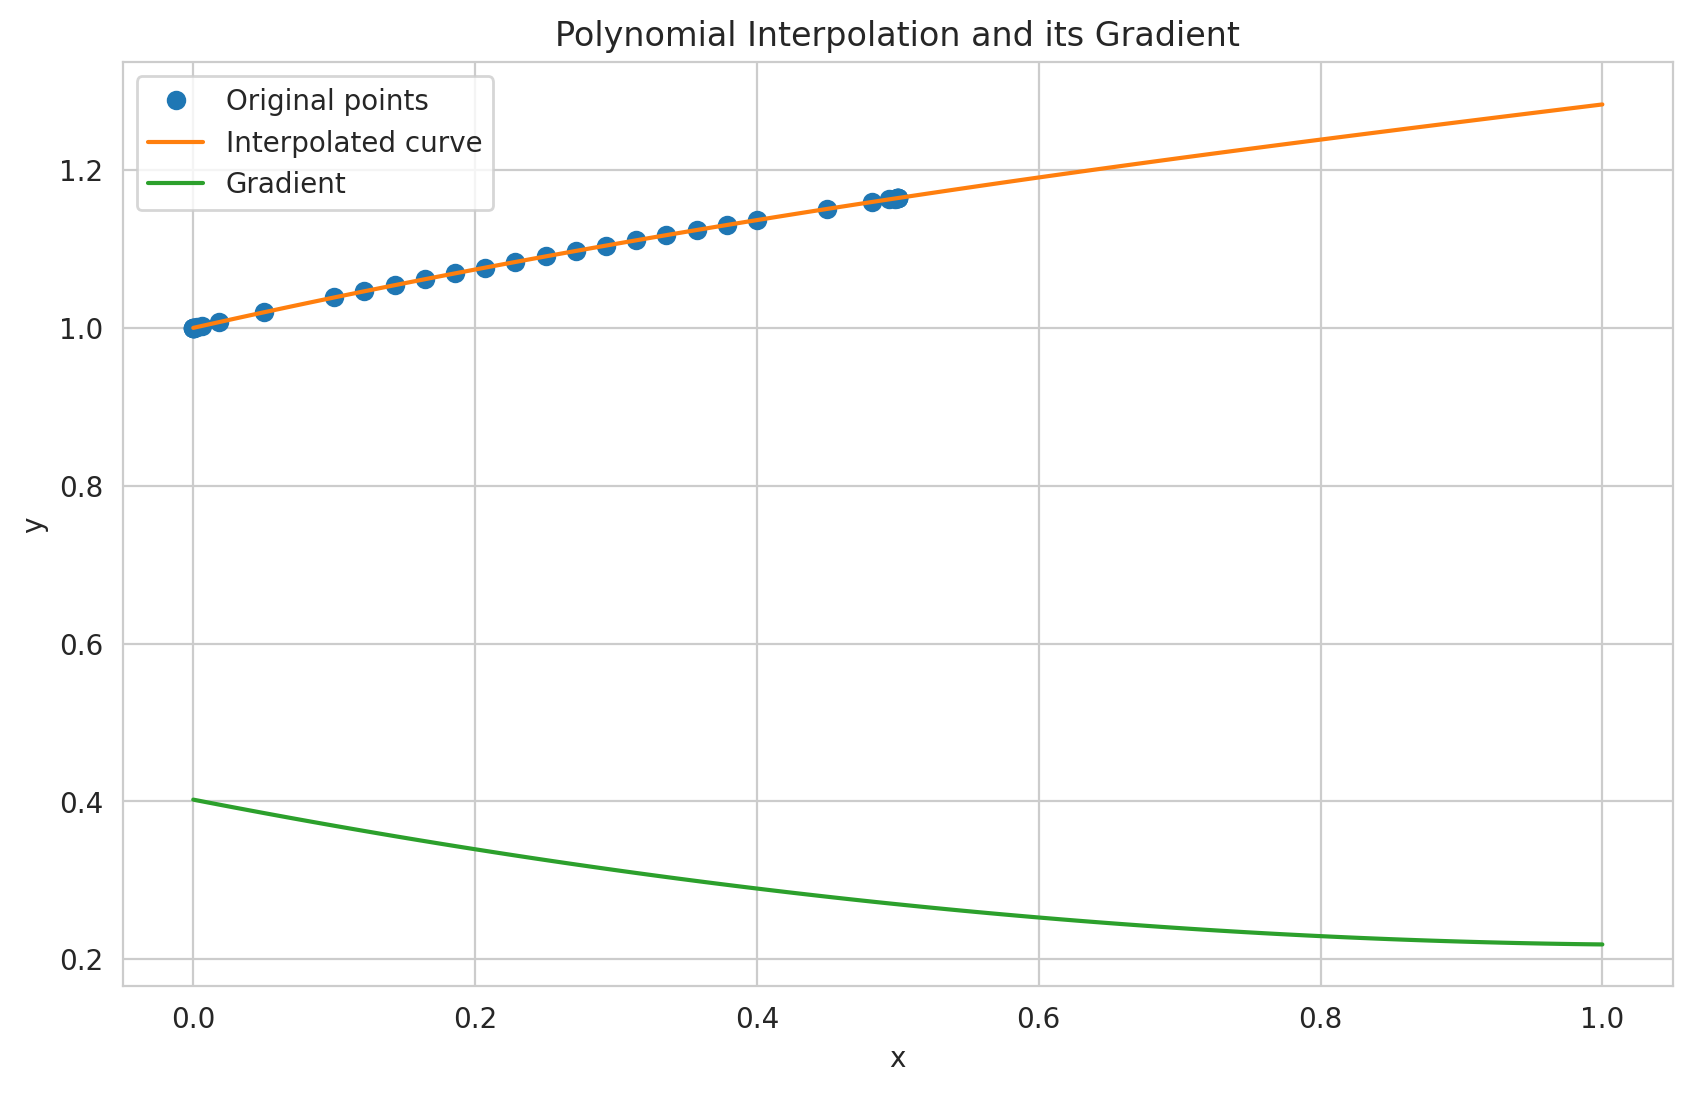

In [ ]:
import jax.numpy as jnp
from jax import jit, grad, vmap

def create_polynomial_interpolator(x, y, degree=3):
    coeffs = jnp.polyfit(x, y, degree)

    @jit
    def interpolate(x_new):
        return jnp.polyval(coeffs, x_new)

    return interpolate

# Example usage:
x = q*df1s
y = (1-q*df1s)/(q*df1s*k2_solns)

interpolator = create_polynomial_interpolator(x, y)
gradient = jit(grad(interpolator))

# Generate points for plotting
x_new = jnp.linspace(0, 1, 100)
y_interp = vmap(interpolator)(x_new)
y_grad = vmap(gradient)(x_new)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Original points')
plt.plot(x_new, y_interp, label='Interpolated curve')
plt.plot(x_new, y_grad, label='Gradient')
plt.legend()
plt.title('Polynomial Interpolation and its Gradient')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

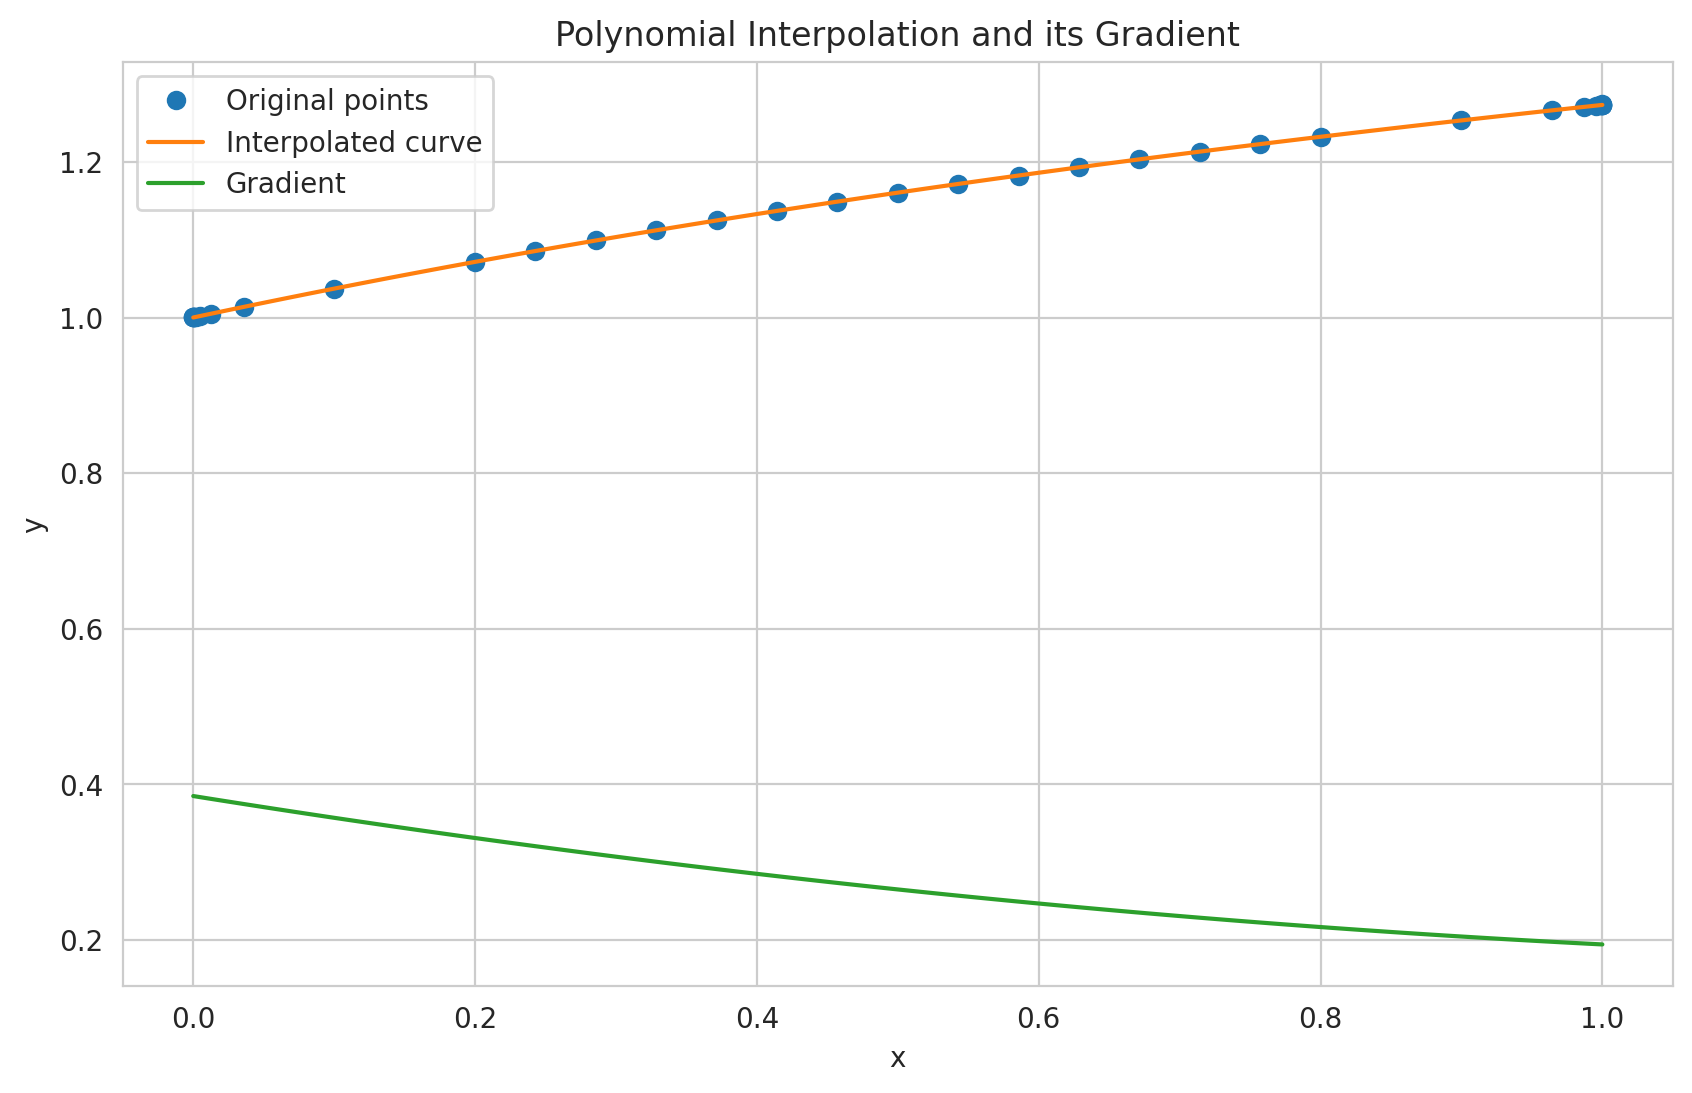

In [ ]:
import jax.numpy as jnp
from jax import jit, grad, vmap

def create_polynomial_interpolator(x, y, degree=3):
    coeffs = jnp.polyfit(x, y, degree)

    @jit
    def interpolate(x_new):
        return jnp.polyval(coeffs, x_new)

    return interpolate

# Example usage:
x = q*df1s
y = (1-q*df1s)/(q*df1s*k2_solns)

interpolator = create_polynomial_interpolator(x, y)
gradient = jit(grad(interpolator))

# Generate points for plotting
x_new = jnp.linspace(0, 1, 100)
y_interp = vmap(interpolator)(x_new)
y_grad = vmap(gradient)(x_new)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Original points')
plt.plot(x_new, y_interp, label='Interpolated curve')
plt.plot(x_new, y_grad, label='Gradient')
plt.legend()
plt.title('Polynomial Interpolation and its Gradient')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

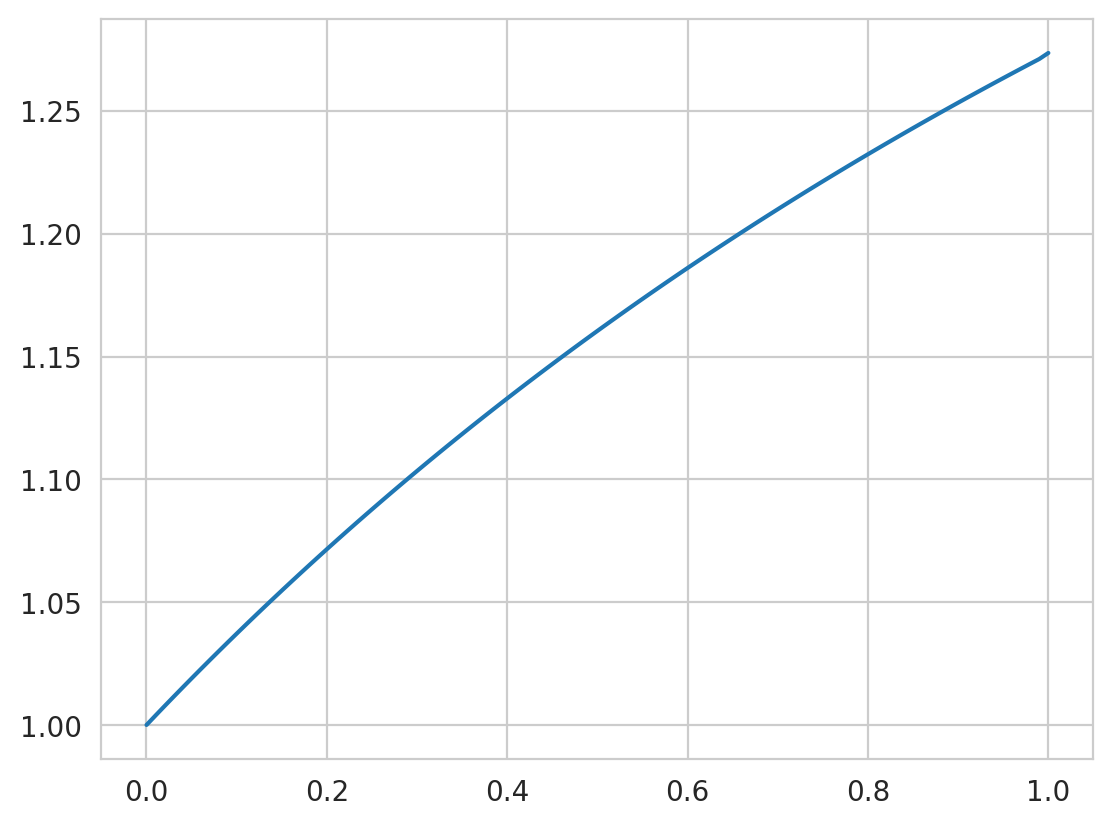

In [ ]:
plt.plot(q*df1s, (1-q*df1s)/(q*df1s*k2_solns))

In [ ]:
kernel_fn = lambda x, y: jnp.exp(-1/2*jnp.abs((x - y)/2)**2)
v_kernel_fn = vmap(lambda x, y: kernel_fn(x, y), in_axes=(None, 0))

def kernel_interpolate(vkernel_fn, x, y, lamb=0.0):
    P = len(x)
    K = v_kernel_fn(x, x)
    alpha = jnp.linalg.solve(K + lamb*jnp.eye(P), y)
    return alpha


S_pts = (1-q*df1s)/(q*df1s*k2_solns)

alpha = kernel_interpolate(kernel_fn, q*df1s, S_pts, lamb=1e-2)

@jit
def k_infer_single(x):
    return alpha.T @ v_kernel_fn(x, log_ls)
k_infer = jit(vmap(k_infer_single))
gk_infer = jit(vmap(grad(k_infer_single)))

In [ ]:
xs = jnp.linspace(0, 1, 100)
plt.plot(xs, k_infer(xs), '-')
plt.plot(q*df1s, S_pts, 'o')
# plt.plot(xs, 10*gk_infer(xs), '-')
# plt.plot(log_ls, [S_exp_corr(b, df1) for df1 in df1s])


TypeError: dot_general requires contracting dimensions to have the same shape, got (100,) and (27,).

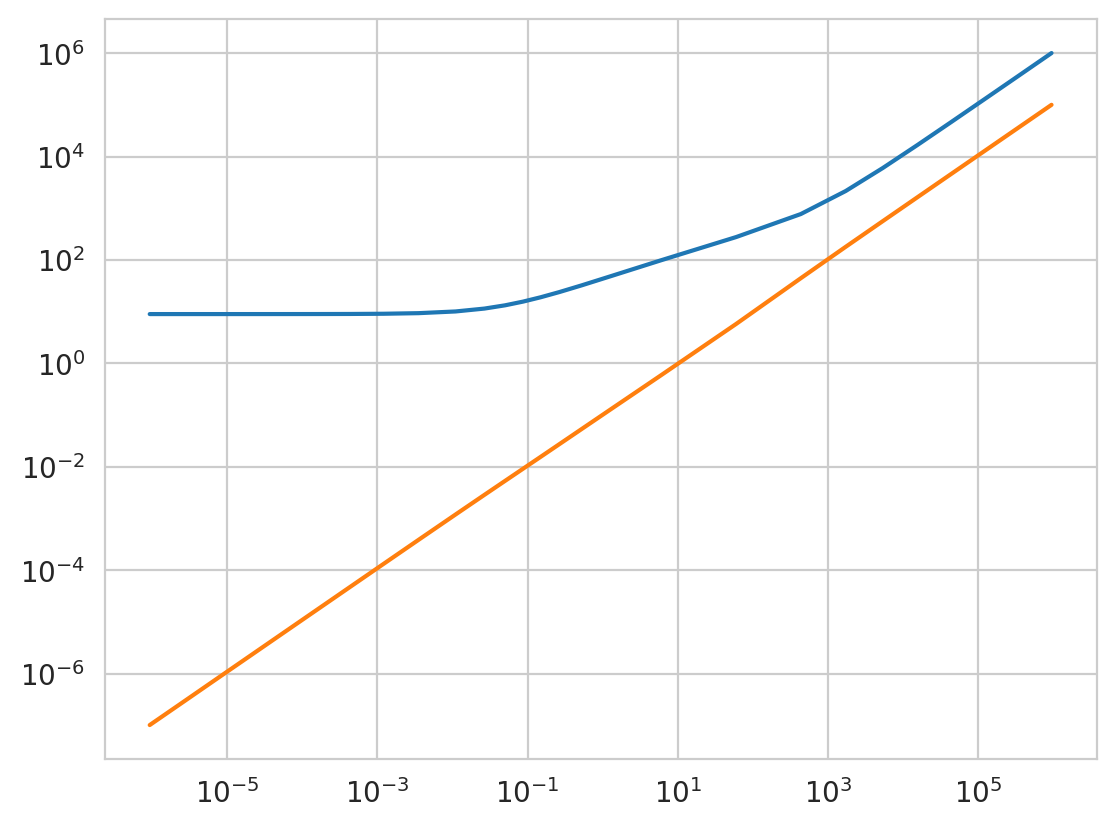

In [ ]:
plt.loglog(l_solns, k1_solns)
plt.loglog(l_solns, k2_solns)

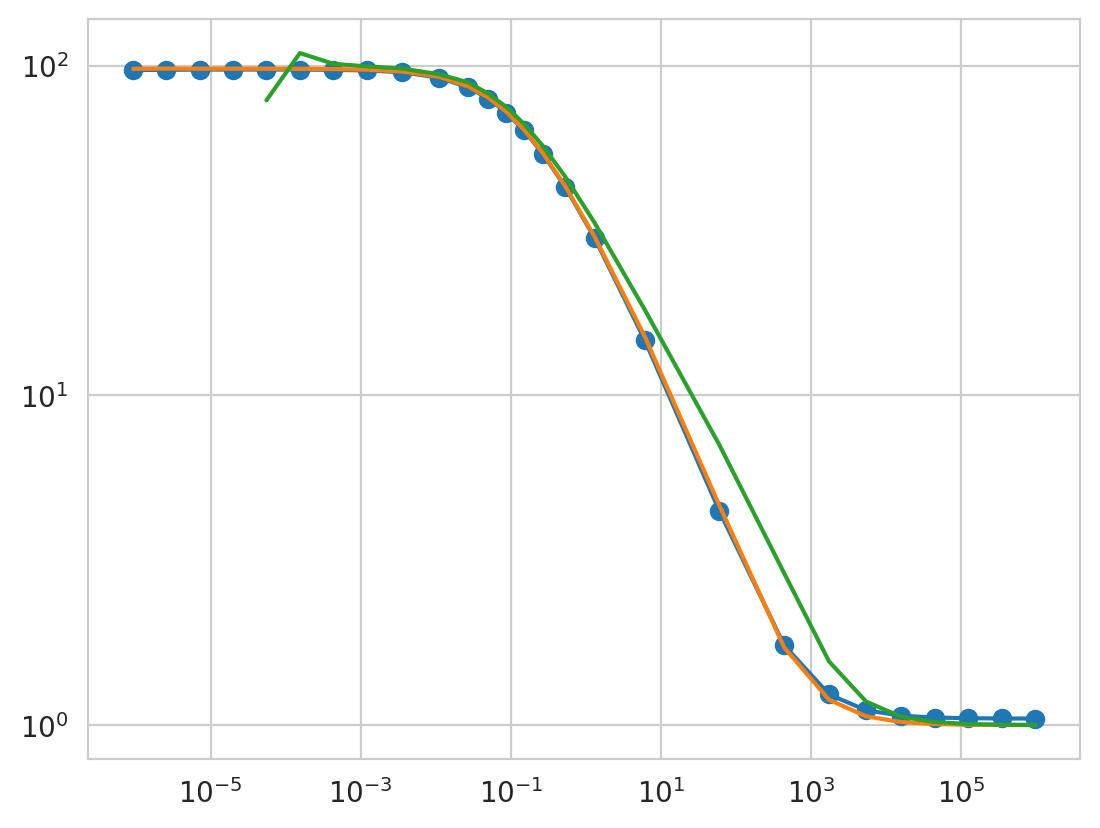

In [ ]:
# plt.semilogy(df1s, (1-df1s)/(df1s*l_solns))
plt.loglog(l_solns, q*(1-df1s)*(1-q*df1s)/(q*df1s*l_solns), 'o-')
plt.loglog(l_solns, (1-q*df1s)/(q*df1s*k2_solns))
plt.loglog(l_solns, [S_exp_corr(b, q*df1) for df1 in df1s])
# plt.loglog(l_solns, k1_solns)
# plt.loglog(l_solns[:10], l_solns[:10])

In [ ]:
log_ls = jnp.log(l_solns)
S_pts = q*(1-df1s)*(1-df1s)/(df1s*l_solns)

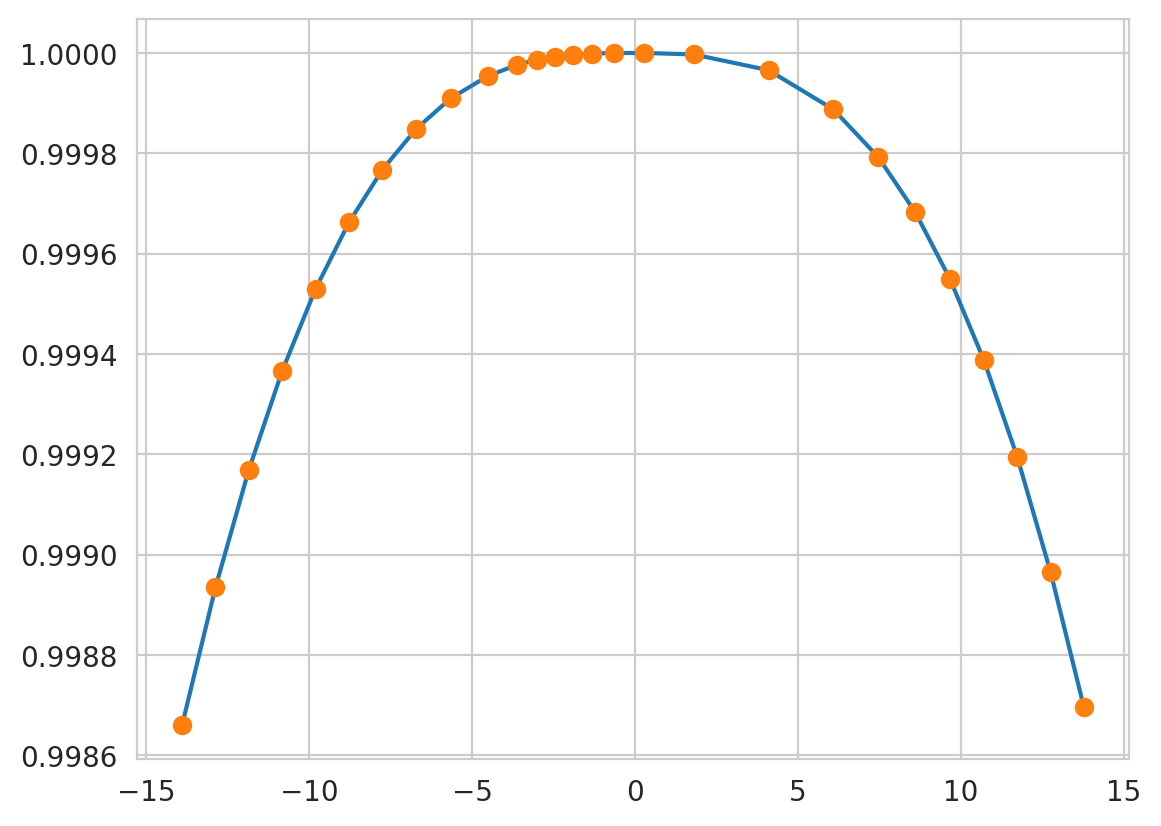

In [ ]:
plt.plot(log_ls, v_kernel_fn(log_ls, jnp.zeros(1,)).flatten())
plt.plot(log_ls, [kernel_fn(l, 0.0) for l in log_ls], 'o')

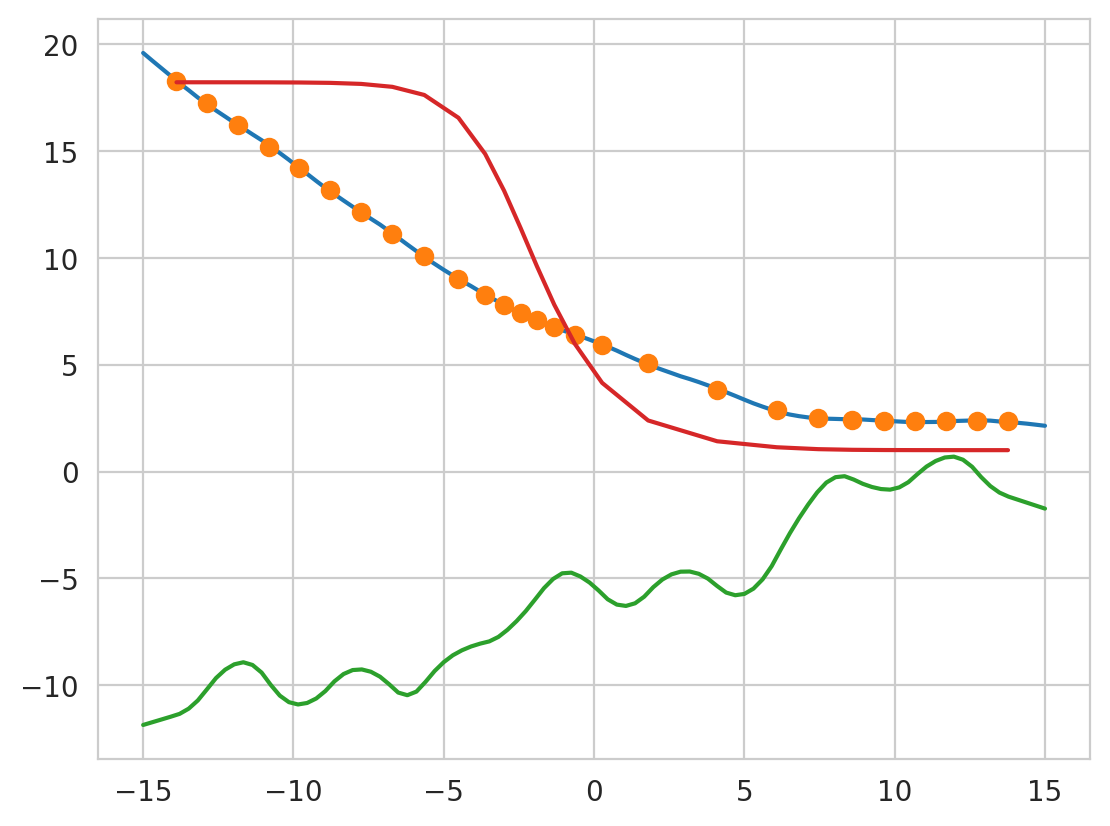

In [ ]:
xs = jnp.linspace(-15, 15, 100)
plt.plot(xs, k_infer(xs), '-')
plt.plot(log_ls, jnp.log(S_pts), 'o')
plt.plot(xs, 10*gk_infer(xs), '-')
plt.plot(log_ls, [S_exp_corr(b, df1) for df1 in df1s])

5.265437
-0.5297919


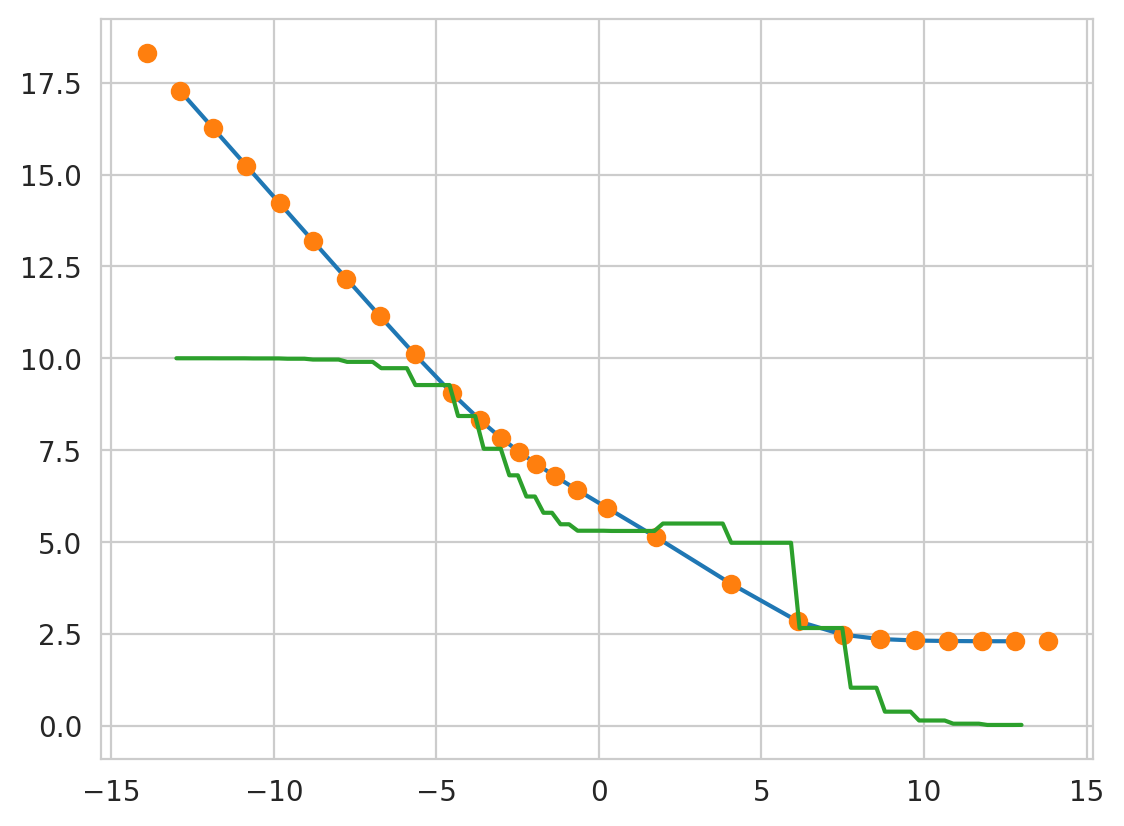

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit

def linear_interpolation(x, y, x_new):
    """
    Linear interpolation function that can be differentiated through.

    Args:
    x: Array of x-coordinates of known points
    y: Array of y-coordinates of known points
    x_new: x-coordinate where we want to interpolate

    Returns:
    Interpolated y-value at x_new
    """
    i = jnp.sum(jnp.where(x <= x_new, 1, 0)) - 1
    i = jnp.clip(i, 0, len(x) - 2)

    x0, x1 = x[i], x[i+1]
    y0, y1 = y[i], y[i+1]

    t = (x_new - x0) / (x1 - x0)
    return y0 + t * (y1 - y0)


# Example usage
x = jnp.array(log_ls)[::-1]
y = jnp.array(jnp.log(S_pts))[::-1]

x_te = jnp.linspace(-13, 13, 100)

interpolate = jit(lambda x_new: linear_interpolation(x, y, x_new))

# Compute the derivative of the interpolation function
dinterpolate_dx = grad(interpolate)

vinterpolate = vmap(interpolate)
vdinterpolate_dx = vmap(dinterpolate_dx)

# Test the interpolation
print(interpolate(1.5))

# Test the derivative
print(dinterpolate_dx(1.5))  # Should give the slope at x=1.5
plt.plot(x_te, vinterpolate(x_te))
plt.plot(x, y, 'o')

plt.plot(x_te, -10*vdinterpolate_dx(x_te))